## Regression Analysis_State-wise_New York

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost.sklearn import XGBRegressor
import xgboost as xgb

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm

In [2]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


## Feature Engineering

In [3]:
data= pd.read_csv('Regression_new.csv')
corr= data.corr()

In [4]:
data

,Year,Month,AK,AL,AR,AZ,CA,CO,CT,DE,...,area,population,solar-generation,Spring,Summer,Fall,Winter,Residential_Usage,Industrial_Usage,Commercial_Usage
0,2014,1,1,0,0,0,0,0,0,0,...,664988,736283,0,0,0,0,1,230.0,122,250
1,2014,1,0,1,0,0,0,0,0,0,...,52420,4841799,0,0,0,0,1,3786.0,2778,1999
2,2014,1,0,0,1,0,0,0,0,0,...,53178,2967392,0,0,0,0,1,2002.0,1303,950
3,2014,1,0,0,0,1,0,0,0,0,...,113990,6730413,34,0,0,0,1,2300.0,1149,2101
4,2014,1,0,0,0,0,1,0,0,0,...,163694,38596972,75,0,0,0,1,7773.0,3764,9426
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3595,2019,12,0,0,0,0,0,0,0,0,...,9616,623651,3,0,0,0,1,203.0,120,162
3596,2019,12,0,0,0,0,0,0,0,0,...,71298,7698332,1,0,0,0,1,3871.0,1979,2611
3597,2019,12,0,0,0,0,0,0,0,0,...,65496,5836210,2,0,0,0,1,2029.0,1859,1954
3598,2019,12,0,0,0,0,0,0,0,0,...,24230,1781015,0,0,0,0,1,1174.0,1176,596


In [5]:
features=['Residential_Retail Price', 'Industrial_Retail Price', 'Commercial_Retail Price','CLDD', 'TAVG', 'AWND', 'HTDD', 'area', 'population', 'solar-generation','Summer', 'Fall', 'Winter', 'Residential_Usage', \
          'Industrial_Usage', 'Commercial_Usage']
#Spring is the seasonal feature baseline
data_NY=data[data.NY==1]
data_NY=data_NY[features]
data_NY

,Residential_Retail Price,Industrial_Retail Price,Commercial_Retail Price,CLDD,TAVG,AWND,HTDD,area,population,solar-generation,Summer,Fall,Winter,Residential_Usage,Industrial_Usage,Commercial_Usage
33,19.57,7.64,16.40,0.000000,18.420714,9.366667,1430.557143,54555,19651049,9,0,0,1,4871.0,1455,6435
83,21.69,8.19,17.48,0.000000,20.139855,8.280645,1248.608696,54555,19651350,10,0,0,1,4550.0,1498,6390
133,20.90,6.84,16.84,0.000000,25.485106,9.403226,1216.255319,54555,19651652,14,0,0,0,4301.0,1379,6231
183,19.54,6.21,14.91,1.637681,44.502174,9.145161,612.123188,54555,19651953,16,0,0,0,3669.0,1427,5894
233,20.59,5.93,15.05,22.702899,57.600725,7.474194,250.637681,54555,19652255,18,0,0,0,3458.0,1539,5922
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3383,18.37,5.74,15.24,128.261539,68.177692,5.568750,30.107692,54555,19408767,86,1,0,0,5586.0,1468,7239
3433,18.70,5.75,15.72,35.213235,61.969853,5.963333,125.595588,54555,19402368,74,0,1,0,4357.0,1420,6618
3483,18.57,5.60,14.60,7.858209,51.791791,7.200000,414.216418,54555,19395969,61,0,1,0,3494.0,1355,5972
3533,18.00,5.44,13.42,0.000000,34.761069,7.906250,898.641221,54555,19389569,41,0,1,0,3527.0,1411,5718


In [6]:
def cal_vif(df, feature_columns):
    features= df[feature_columns]
    X = add_constant(features)
    vif=pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)
    
    return vif

In [7]:
commercial_numeric_columns=['Commercial_Retail Price', 'CLDD', 'TAVG', 'AWND', 'HTDD', 'area', 'population', 'solar-generation']
residential_numeric_columns=['Residential_Retail Price', 'CLDD', 'TAVG', 'AWND', 'HTDD', 'area', 'population', 'solar-generation']
industrial_numeric_columns=['Industrial_Retail Price', 'CLDD', 'TAVG', 'AWND', 'HTDD', 'area', 'population', 'solar-generation']

In [8]:
cal_vif(data_NY, commercial_numeric_columns)

Commercial_Retail Price         2.220341
CLDD                            8.077153
TAVG                          334.845890
AWND                            5.886504
HTDD                          281.756066
area                       340562.822144
population                      6.570350
solar-generation                6.872330
dtype: float64

In [9]:
cal_vif(data_NY, residential_numeric_columns)

Residential_Retail Price         1.332631
CLDD                             7.937355
TAVG                           348.488427
AWND                             5.472309
HTDD                           292.755591
area                        319979.391598
population                       6.090525
solar-generation                 6.864666
dtype: float64

In [10]:
cal_vif(data_NY, industrial_numeric_columns)

Industrial_Retail Price         1.653804
CLDD                            7.887929
TAVG                          343.735017
AWND                            5.796430
HTDD                          284.704359
area                       365888.603851
population                      7.140433
solar-generation                7.082131
dtype: float64

Since `TAVG` and `area` goe large VIF, we decided to delete these two columns.

In [11]:
commercial_numeric_columns_adj=['Commercial_Retail Price', 'CLDD','AWND', 'HTDD', 'population', 'solar-generation']
cal_vif(data_NY, commercial_numeric_columns_adj)

const                      334523.976610
Commercial_Retail Price         2.192524
CLDD                            2.840211
AWND                            5.884754
HTDD                            6.067612
population                      6.569477
solar-generation                6.866836
dtype: float64

In [12]:
industrial_numeric_columns_adj=['Industrial_Retail Price', 'CLDD','AWND', 'HTDD', 'population', 'solar-generation']
cal_vif(data_NY, industrial_numeric_columns_adj)

const                      363339.602378
Industrial_Retail Price         1.590853
CLDD                            2.676490
AWND                            5.786472
HTDD                            6.902401
population                      7.130933
solar-generation                7.082066
dtype: float64

In [13]:
residential_numeric_columns_adj=['Residential_Retail Price', 'CLDD','AWND', 'HTDD', 'population', 'solar-generation']
cal_vif(data_NY, residential_numeric_columns_adj)

const                       313570.798723
Residential_Retail Price         1.264419
CLDD                             2.674296
AWND                             5.467884
HTDD                             5.990575
population                       6.090031
solar-generation                 6.858541
dtype: float64

In [14]:
data_NY= data_NY.drop(['TAVG', 'area'],axis = 1)

## Train Test Split and Data Scaling

In [15]:
#Train-Test Split
train, test = train_test_split(data_NY, test_size=0.2)

#splitX,y
def x_y_split(data, y_name, drop_features):
    X = data.drop(drop_features, axis = 1)
    y = data[y_name]
    return X,y

X_train_c, y_train_c = x_y_split(train, 'Commercial_Usage', ['Industrial_Retail Price', 'Residential_Retail Price',\
                                                             'Residential_Usage', 'Industrial_Usage', 'Commercial_Usage'])
X_test_c,y_test_c = x_y_split(test, 'Commercial_Usage', ['Industrial_Retail Price', 'Residential_Retail Price',\
                                                         'Residential_Usage', 'Industrial_Usage', 'Commercial_Usage'])

X_train_r, y_train_r = x_y_split(train, 'Residential_Usage', ['Industrial_Retail Price', 'Commercial_Retail Price',\
                                                             'Residential_Usage', 'Industrial_Usage', 'Commercial_Usage'])
X_test_r,y_test_r = x_y_split(test, 'Residential_Usage', ['Industrial_Retail Price', 'Commercial_Retail Price',\
                                                         'Residential_Usage', 'Industrial_Usage', 'Commercial_Usage'])

X_train_i, y_train_i = x_y_split(train, 'Industrial_Usage', ['Commercial_Retail Price', 'Residential_Retail Price',\
                                                             'Residential_Usage', 'Industrial_Usage', 'Commercial_Usage'])
X_test_i,y_test_i = x_y_split(test, 'Industrial_Usage', ['Commercial_Retail Price', 'Residential_Retail Price',\
                                                         'Residential_Usage', 'Industrial_Usage', 'Commercial_Usage'])

In [16]:
train.columns

Index(['Residential_Retail Price', 'Industrial_Retail Price',
       'Commercial_Retail Price', 'CLDD', 'AWND', 'HTDD', 'population',
       'solar-generation', 'Summer', 'Fall', 'Winter', 'Residential_Usage',
       'Industrial_Usage', 'Commercial_Usage'],
      dtype='object')

In [17]:
#categorize X features
categorical_feature_name = ['Summer', 'Fall', 'Winter']

In [18]:
#Scale the data through Robust Scaler

def minmax_scaler(X_train, X_test, numeric_feature_name):
    minMax_Scaler = MinMaxScaler()
    # fit and tranform the training data
    X_train[numeric_feature_name] = minMax_Scaler.fit_transform(X_train[numeric_feature_name]) 
    # tranform test data
    X_test[numeric_feature_name] = minMax_Scaler.transform(X_test[numeric_feature_name]) 
    return (X_train,X_test)

X_train_c, X_test_c = minmax_scaler(X_train_c, X_test_c, commercial_numeric_columns_adj)
X_train_r, X_test_r = minmax_scaler(X_train_r, X_test_r, residential_numeric_columns_adj)
X_train_i, X_test_i = minmax_scaler(X_train_i, X_test_i, industrial_numeric_columns_adj)

### Commercial Consumption Forecast

### Commercial_Linear Regression

In [19]:
def sm_regression(X_train,y_train,X_test,y_test):
    X_train = sm.add_constant(X_train)
    X_test = sm.add_constant(X_test)

    model = sm.OLS(y_train,X_train)
    results = model.fit()
    results.params
    print(results.summary())
    predictions = results.predict(X_test)
    df_pred = pd.DataFrame({'Actual': y_test.squeeze(), 'Predicted': predictions})
    
    return df_pred

In [20]:
df_pred_c=sm_regression(X_train_c, y_train_c, X_test_c, y_test_c)

                            OLS Regression Results                            
Dep. Variable:       Commercial_Usage   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     31.99
Date:                Wed, 22 Jul 2020   Prob (F-statistic):           4.07e-17
Time:                        06:31:08   Log-Likelihood:                -380.61
No. Observations:                  57   AIC:                             781.2
Df Residuals:                      47   BIC:                             801.7
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    5

In [21]:
df_pred_c

,Actual,Predicted
83,6390,6765.678433
1183,6131,6213.760549
1683,6145,6209.232587
933,7126,7088.782123
1383,5675,5818.551294
3583,6168,6226.082953
1483,6488,6375.585941
3533,5718,6131.874360
2183,7050,6792.891070
1733,5849,6132.723147


In [22]:
#Evaluate Performance: MAE, MSE, RMSE
def evaluate_performances(y_test, y_pred):
    print('Performance Evaluation')
    print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))  
    print('Mean Squared Error:', mean_squared_error(y_test, y_pred))  
    print('Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test, y_pred)))

In [23]:
# Evaluate Performance
evaluate_performances(df_pred_c['Actual'], df_pred_c['Predicted'])

Performance Evaluation
Mean Absolute Error: 168.12041966503207
Mean Squared Error: 44454.0082930909
Root Mean Squared Error: 210.84119211646214


### Commercial_Feature Importance

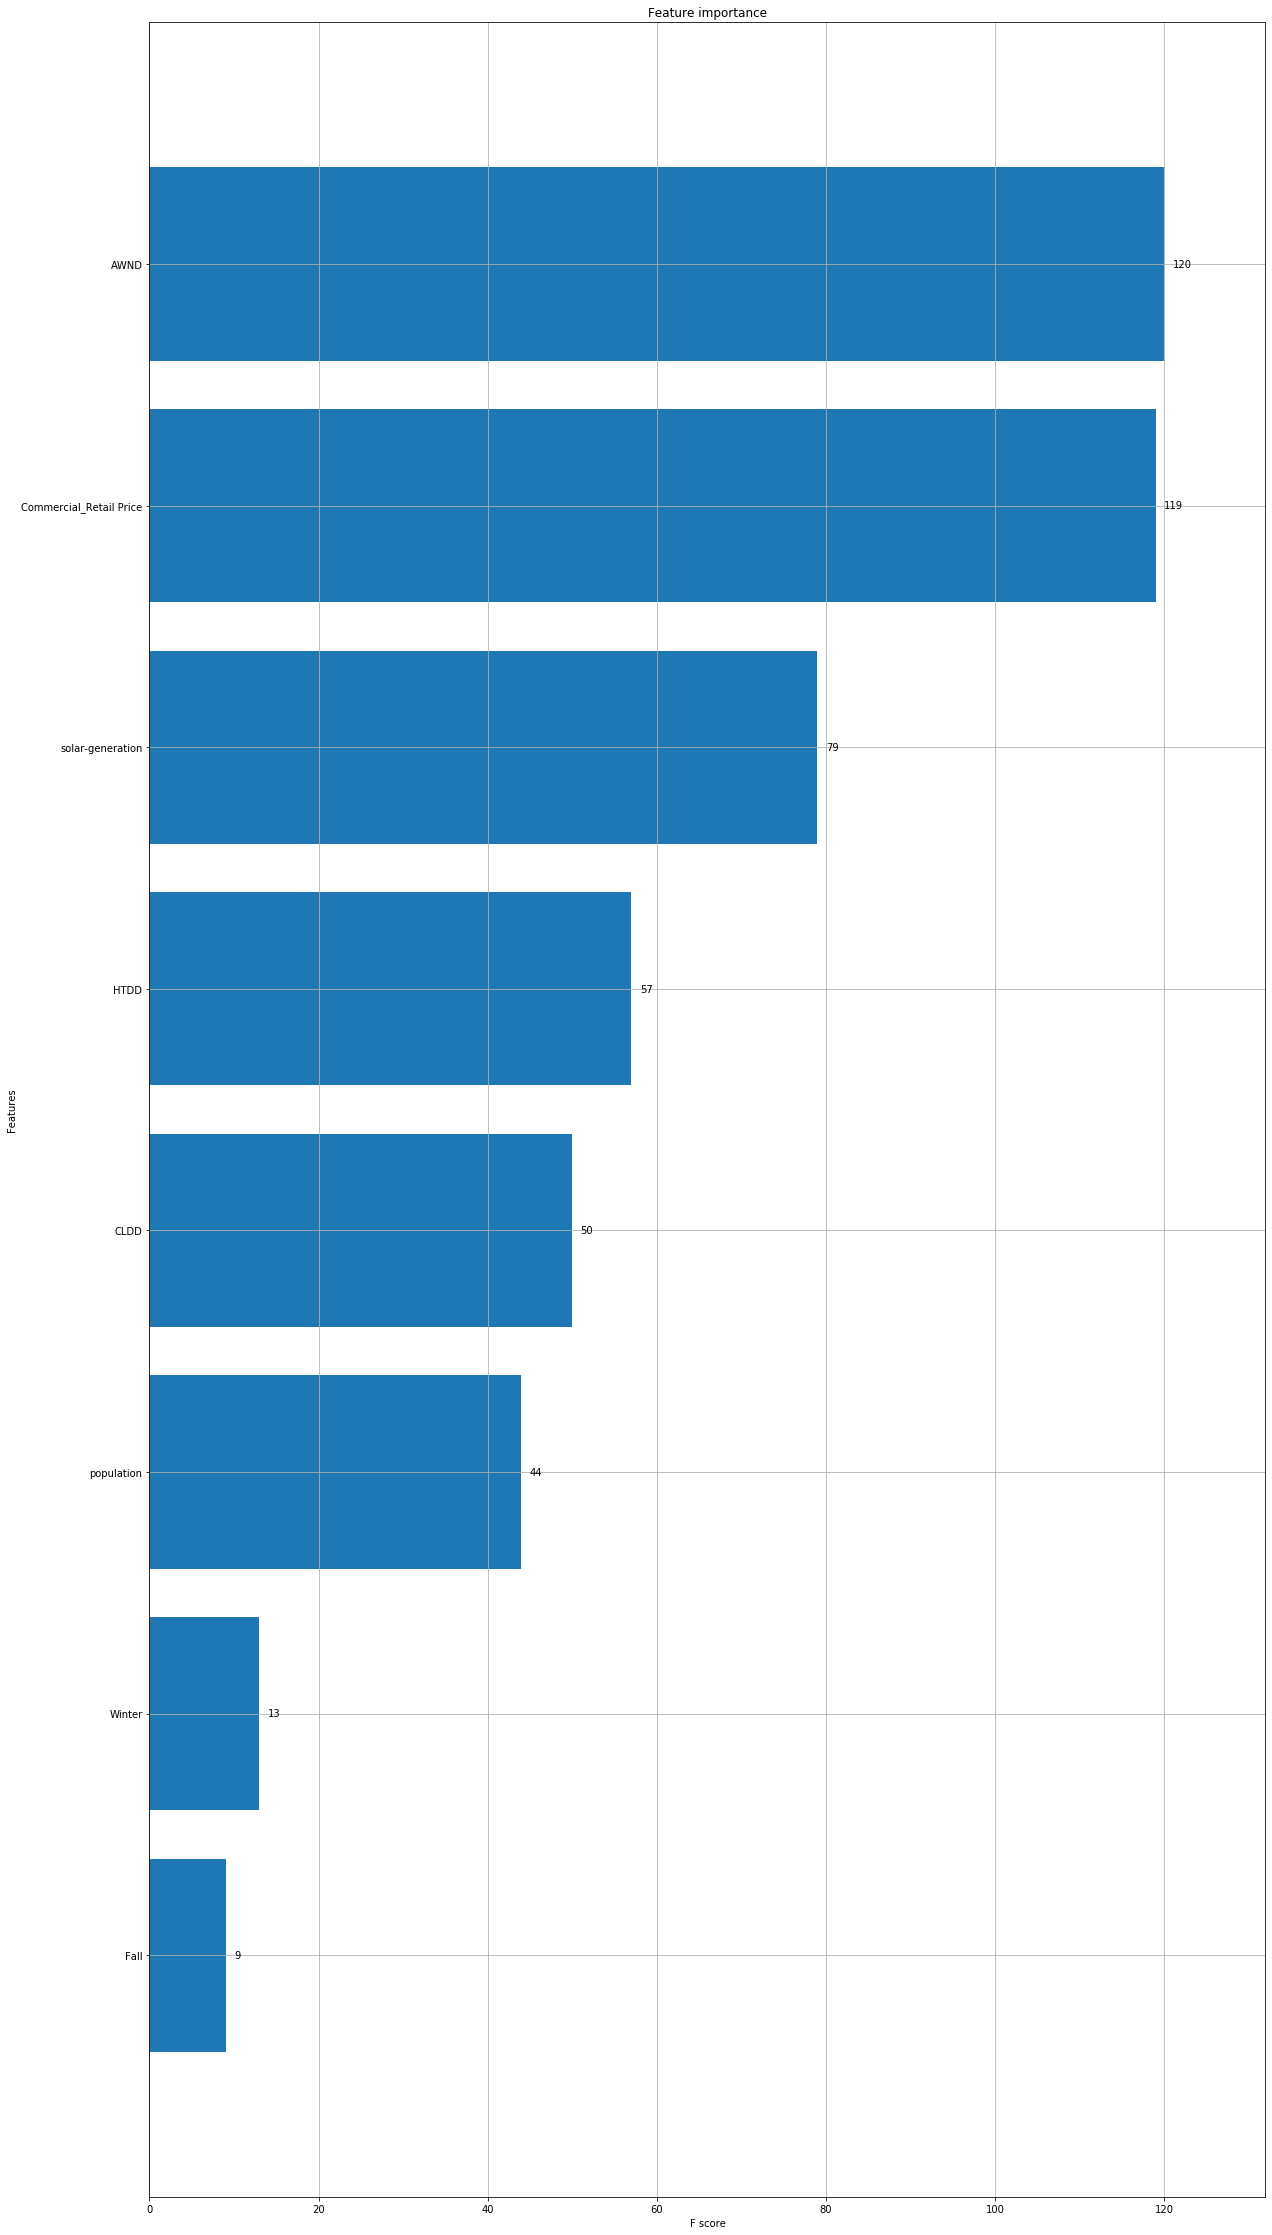

In [24]:
xgbRegressor = XGBRegressor(objective ='reg:squarederror')
xgbRegressor.fit(X_train_c, y_train_c)

fig, ax = plt.subplots(figsize=(20,40))
xgb.plot_importance(xgbRegressor, height=0.8, ax=ax)

### Commercial_Regression_Visualizations

In [25]:
# Correlation Analysis between Y and X's
def correlation_analysis(data, x_vars_list, y_vars_list):
    sns.pairplot(data, x_vars = x_vars_list, y_vars = y_vars_list, size=7, aspect=0.8,kind = 'reg')
#     plt.savefig("pairplot.jpg")
    plt.show()

In [26]:
#Visualize the output
def visualize_graph(df_pred):
    fig, axes = plt.subplots(3,1, figsize=(7,15))
    #Plot the result in line plot
    df_pred.plot.scatter(title="Actual vs. Predict result scatter plot",x='Actual', y='Predicted',ax=axes[0])
    #Plot the result in box plot
    df_pred.plot(title="Actual vs. Predict result box plot",kind='box',ax=axes[1])
    #Plot the result in terms of kernel density estimation
    df_pred.plot(title="Actual vs. Predict result kernel density estimation", kind='density',ax=axes[2]) 

In [27]:
# Visualization
def visualization(y_test, y_pred):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(30,20))
    fig.suptitle('Predicted and Actual plot')
    ax1.plot(range(len(y_pred)),y_pred,'b',label="predict")
    ax1.legend(loc="upper right")
    ax2.plot(range(len(y_test)),y_test,'r',label="actual")
    ax2.legend(loc="upper right")
    ax3.plot(range(len(y_pred)),y_pred,'b',label="predict")
    ax3.plot(range(len(y_test)),y_test,'r',label="test")
    ax3.legend(loc="upper right")
    plt.show()

C:\Users\Maggie\Anaconda3\envs\tensorflow_env\lib\site-packages\seaborn\axisgrid.py:2079: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


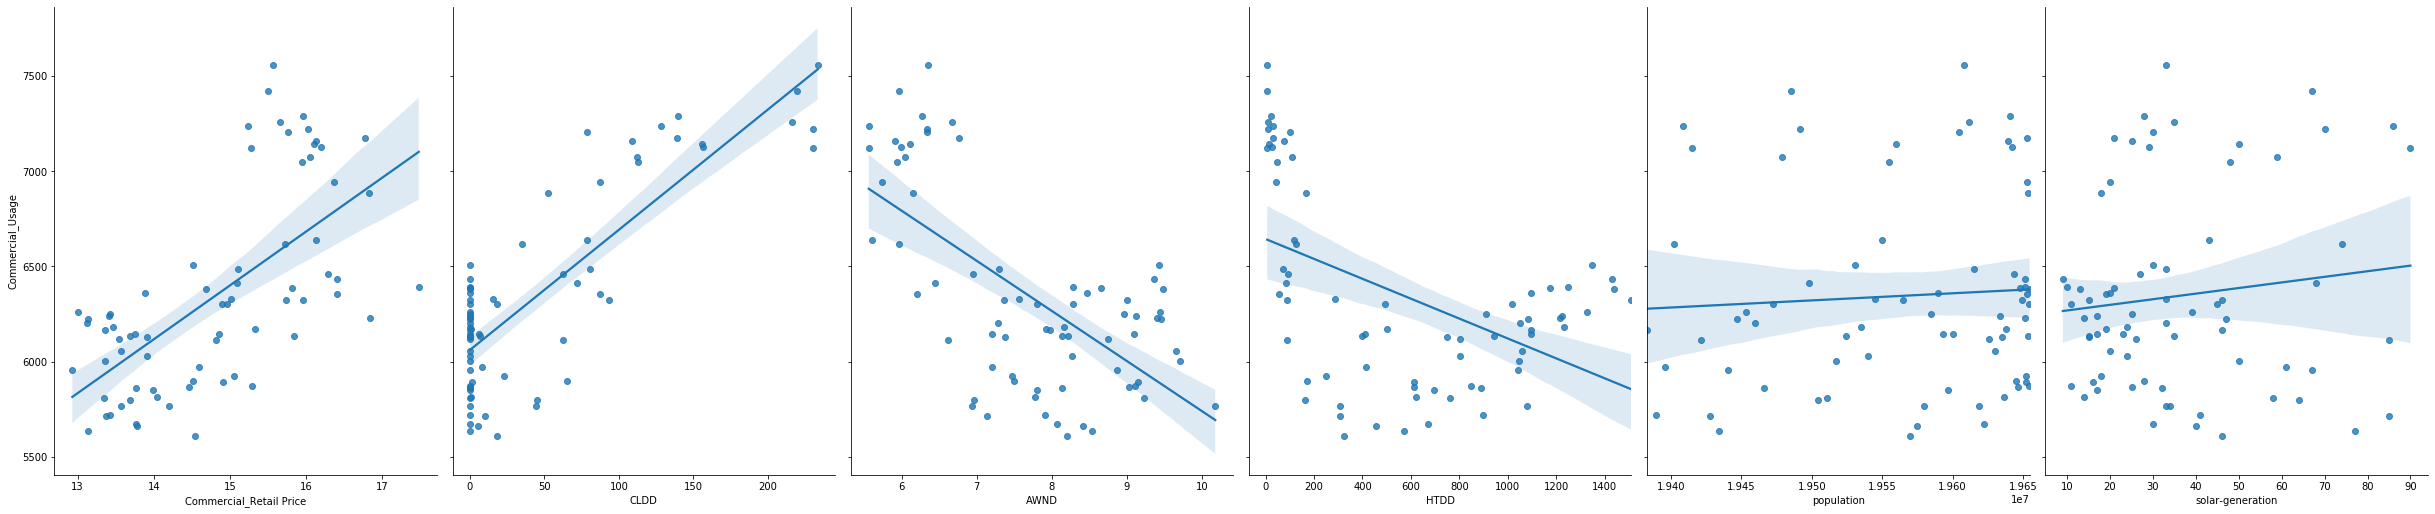

In [28]:
# Correlation Analysis
correlation_analysis(data_NY, commercial_numeric_columns_adj, ['Commercial_Usage'])

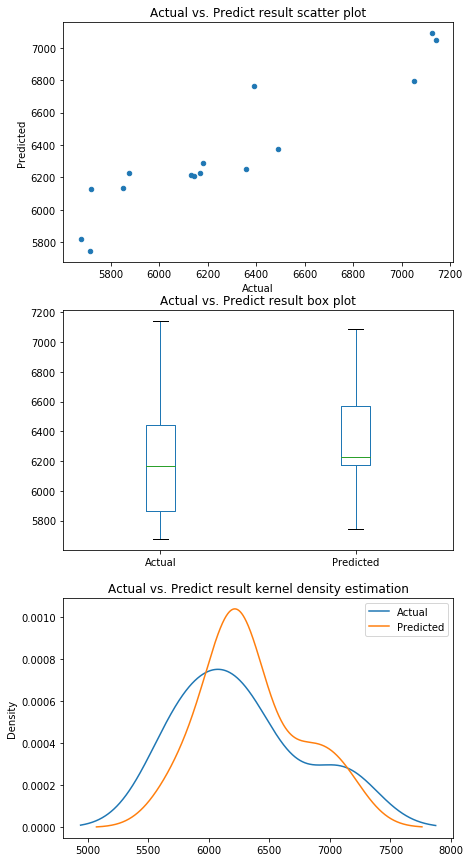

In [29]:
# Visualize Output
visualize_graph(df_pred_c)

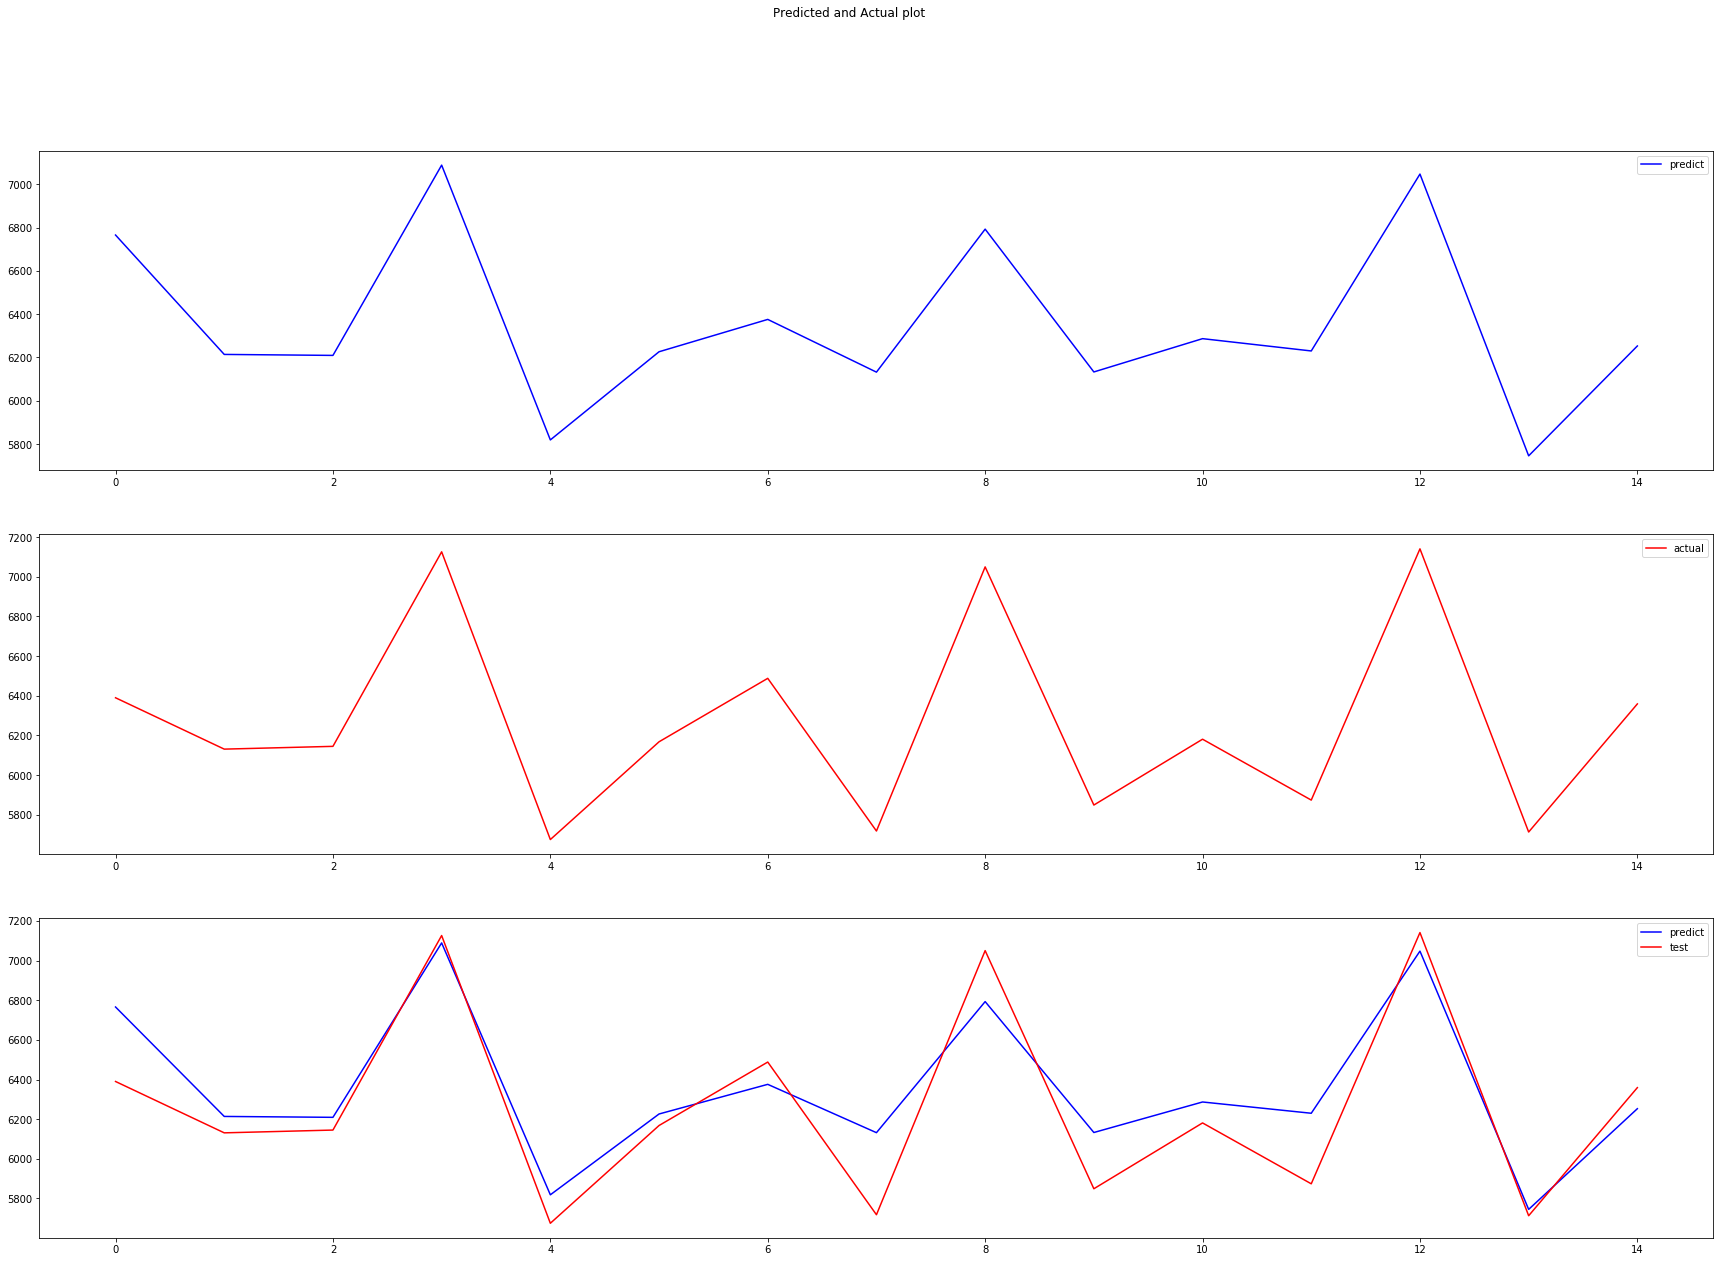

In [30]:
visualization(df_pred_c.Actual, df_pred_c.Predicted)

### Commercial_ANN

In [116]:
features_ANN_c=['Year', 'Month', 'Commercial_Usage', 'CLDD', 'AWND', 'HTDD', 'population', 'solar-generation','Summer', 'Fall', 'Winter', 'Commercial_Retail Price']
#Spring is the seasonal feature baseline
data_NY_ANN=data[data.NY==1]
data_NY_ANN=data_NY_ANN[features_ANN_c]
data_NY_ANN

,Year,Month,Commercial_Usage,CLDD,AWND,HTDD,population,solar-generation,Summer,Fall,Winter,Commercial_Retail Price
33,2014,1,6435,0.000000,9.366667,1430.557143,19651049,9,0,0,1,16.40
83,2014,2,6390,0.000000,8.280645,1248.608696,19651350,10,0,0,1,17.48
133,2014,3,6231,0.000000,9.403226,1216.255319,19651652,14,0,0,0,16.84
183,2014,4,5894,1.637681,9.145161,612.123188,19651953,16,0,0,0,14.91
233,2014,5,5922,22.702899,7.474194,250.637681,19652255,18,0,0,0,15.05
...,...,...,...,...,...,...,...,...,...,...,...,...
3383,2019,8,7239,128.261539,5.568750,30.107692,19408767,86,1,0,0,15.24
3433,2019,9,6618,35.213235,5.963333,125.595588,19402368,74,0,1,0,15.72
3483,2019,10,5972,7.858209,7.200000,414.216418,19395969,61,0,1,0,14.60
3533,2019,11,5718,0.000000,7.906250,898.641221,19389569,41,0,1,0,13.42


In [117]:
train_ANN, test_ANN = train_test_split(data_NY_ANN, test_size=0.2)
X_train_ANN_c, y_train_ANN_c = x_y_split(train_ANN, 'Commercial_Usage', ['Commercial_Usage'])
X_test_ANN_c,y_test_ANN_c = x_y_split(test_ANN, 'Commercial_Usage', ['Commercial_Usage'])

In [118]:
X_train_ANN_c, X_test_ANN_c = minmax_scaler(X_train_ANN_c, X_test_ANN_c, commercial_numeric_columns_adj)
y_train_ANN_c = (y_train_ANN_c - min(y_train_ANN_c))/(max(y_train_ANN_c) - min(y_train_ANN_c))

In [119]:
# Initialising the ANN
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 15, kernel_initializer = 'uniform', activation = 'relu', input_dim = 11))

# Adding the second hidden layer
classifier.add(Dense(units = 5, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mae'])

# Fitting the ANN to the training set
classifier.fit(X_train_ANN_c, y_train_ANN_c, validation_split = 0.2, batch_size = 10, epochs = 1800)

Train on 45 samples, validate on 12 samples
Epoch 1/1800
45/45 [==============================] - 1s 21ms/step - loss: 0.0845 - mae: 0.2573 - val_loss: 0.0358 - val_mae: 0.1783
Epoch 2/1800
45/45 [==============================] - 0s 443us/step - loss: 0.0806 - mae: 0.2365 - val_loss: 0.0294 - val_mae: 0.1349
Epoch 3/1800
45/45 [==============================] - 0s 443us/step - loss: 0.0796 - mae: 0.2196 - val_loss: 0.0291 - val_mae: 0.1277
Epoch 4/1800
45/45 [==============================] - 0s 488us/step - loss: 0.0800 - mae: 0.2193 - val_loss: 0.0293 - val_mae: 0.1329
Epoch 5/1800
45/45 [==============================] - 0s 488us/step - loss: 0.0801 - mae: 0.2247 - val_loss: 0.0313 - val_mae: 0.1553
Epoch 6/1800
45/45 [==============================] - 0s 488us/step - loss: 0.0786 - mae: 0.2292 - val_loss: 0.0321 - val_mae: 0.1602
Epoch 7/1800
45/45 [==============================] - 0s 510us/step - loss: 0.0790 - mae: 0.2309 - val_loss: 0.0318 - val_mae: 0.1587
Epoch 8/1800
45/45 

45/45 [==============================] - 0s 421us/step - loss: 0.0783 - mae: 0.2271 - val_loss: 0.0310 - val_mae: 0.1539
Epoch 62/1800
45/45 [==============================] - 0s 465us/step - loss: 0.0782 - mae: 0.2271 - val_loss: 0.0308 - val_mae: 0.1524
Epoch 63/1800
45/45 [==============================] - 0s 421us/step - loss: 0.0780 - mae: 0.2254 - val_loss: 0.0301 - val_mae: 0.1467
Epoch 64/1800
45/45 [==============================] - 0s 421us/step - loss: 0.0784 - mae: 0.2227 - val_loss: 0.0294 - val_mae: 0.1381
Epoch 65/1800
45/45 [==============================] - 0s 443us/step - loss: 0.0785 - mae: 0.2221 - val_loss: 0.0297 - val_mae: 0.1420
Epoch 66/1800
45/45 [==============================] - 0s 465us/step - loss: 0.0784 - mae: 0.2225 - val_loss: 0.0299 - val_mae: 0.1439
Epoch 67/1800
45/45 [==============================] - 0s 443us/step - loss: 0.0782 - mae: 0.2233 - val_loss: 0.0301 - val_mae: 0.1467
Epoch 68/1800
45/45 [==============================] - 0s 465us/step 

Epoch 121/1800
45/45 [==============================] - 0s 443us/step - loss: 0.0770 - mae: 0.2286 - val_loss: 0.0327 - val_mae: 0.1662
Epoch 122/1800
45/45 [==============================] - 0s 465us/step - loss: 0.0767 - mae: 0.2293 - val_loss: 0.0318 - val_mae: 0.1616
Epoch 123/1800
45/45 [==============================] - 0s 443us/step - loss: 0.0761 - mae: 0.2241 - val_loss: 0.0295 - val_mae: 0.1453
Epoch 124/1800
45/45 [==============================] - 0s 488us/step - loss: 0.0761 - mae: 0.2188 - val_loss: 0.0287 - val_mae: 0.1352
Epoch 125/1800
45/45 [==============================] - 0s 465us/step - loss: 0.0768 - mae: 0.2180 - val_loss: 0.0289 - val_mae: 0.1389
Epoch 126/1800
45/45 [==============================] - 0s 465us/step - loss: 0.0768 - mae: 0.2177 - val_loss: 0.0287 - val_mae: 0.1365
Epoch 127/1800
45/45 [==============================] - 0s 421us/step - loss: 0.0769 - mae: 0.2170 - val_loss: 0.0290 - val_mae: 0.1407
Epoch 128/1800
45/45 [==========================

45/45 [==============================] - 0s 488us/step - loss: 0.0599 - mae: 0.1982 - val_loss: 0.0289 - val_mae: 0.1586
Epoch 182/1800
45/45 [==============================] - 0s 443us/step - loss: 0.0585 - mae: 0.2002 - val_loss: 0.0245 - val_mae: 0.1338
Epoch 183/1800
45/45 [==============================] - 0s 488us/step - loss: 0.0590 - mae: 0.1970 - val_loss: 0.0244 - val_mae: 0.1343
Epoch 184/1800
45/45 [==============================] - 0s 443us/step - loss: 0.0585 - mae: 0.1994 - val_loss: 0.0240 - val_mae: 0.1311
Epoch 185/1800
45/45 [==============================] - 0s 510us/step - loss: 0.0579 - mae: 0.1924 - val_loss: 0.0235 - val_mae: 0.1277
Epoch 186/1800
45/45 [==============================] - 0s 465us/step - loss: 0.0600 - mae: 0.2097 - val_loss: 0.0286 - val_mae: 0.1577
Epoch 187/1800
45/45 [==============================] - 0s 465us/step - loss: 0.0588 - mae: 0.1989 - val_loss: 0.0221 - val_mae: 0.1086
Epoch 188/1800
45/45 [==============================] - 0s 443u

45/45 [==============================] - 0s 465us/step - loss: 0.0441 - mae: 0.1801 - val_loss: 0.0200 - val_mae: 0.0933
Epoch 242/1800
45/45 [==============================] - 0s 443us/step - loss: 0.0431 - mae: 0.1740 - val_loss: 0.0218 - val_mae: 0.1198
Epoch 243/1800
45/45 [==============================] - 0s 465us/step - loss: 0.0445 - mae: 0.1813 - val_loss: 0.0194 - val_mae: 0.0932
Epoch 244/1800
45/45 [==============================] - 0s 465us/step - loss: 0.0473 - mae: 0.1824 - val_loss: 0.0236 - val_mae: 0.1285
Epoch 245/1800
45/45 [==============================] - 0s 465us/step - loss: 0.0482 - mae: 0.1884 - val_loss: 0.0192 - val_mae: 0.1028
Epoch 246/1800
45/45 [==============================] - 0s 465us/step - loss: 0.0471 - mae: 0.1842 - val_loss: 0.0200 - val_mae: 0.1085
Epoch 247/1800
45/45 [==============================] - 0s 488us/step - loss: 0.0429 - mae: 0.1769 - val_loss: 0.0204 - val_mae: 0.0941
Epoch 248/1800
45/45 [==============================] - 0s 465u

45/45 [==============================] - 0s 443us/step - loss: 0.0351 - mae: 0.1622 - val_loss: 0.0200 - val_mae: 0.0968
Epoch 302/1800
45/45 [==============================] - ETA: 0s - loss: 0.0304 - mae: 0.159 - 0s 443us/step - loss: 0.0363 - mae: 0.1659 - val_loss: 0.0199 - val_mae: 0.0937
Epoch 303/1800
45/45 [==============================] - 0s 465us/step - loss: 0.0362 - mae: 0.1639 - val_loss: 0.0212 - val_mae: 0.1065
Epoch 304/1800
45/45 [==============================] - 0s 465us/step - loss: 0.0363 - mae: 0.1669 - val_loss: 0.0197 - val_mae: 0.0929
Epoch 305/1800
45/45 [==============================] - 0s 465us/step - loss: 0.0346 - mae: 0.1602 - val_loss: 0.0197 - val_mae: 0.0928
Epoch 306/1800
45/45 [==============================] - 0s 621us/step - loss: 0.0344 - mae: 0.1607 - val_loss: 0.0201 - val_mae: 0.0972
Epoch 307/1800
45/45 [==============================] - 0s 621us/step - loss: 0.0370 - mae: 0.1655 - val_loss: 0.0201 - val_mae: 0.0971
Epoch 308/1800
45/45 [===

45/45 [==============================] - 0s 488us/step - loss: 0.0316 - mae: 0.1559 - val_loss: 0.0230 - val_mae: 0.1071
Epoch 362/1800
45/45 [==============================] - 0s 488us/step - loss: 0.0304 - mae: 0.1519 - val_loss: 0.0220 - val_mae: 0.1043
Epoch 363/1800
45/45 [==============================] - 0s 465us/step - loss: 0.0323 - mae: 0.1563 - val_loss: 0.0217 - val_mae: 0.0986
Epoch 364/1800
45/45 [==============================] - 0s 488us/step - loss: 0.0313 - mae: 0.1547 - val_loss: 0.0207 - val_mae: 0.0914
Epoch 365/1800
45/45 [==============================] - 0s 488us/step - loss: 0.0312 - mae: 0.1547 - val_loss: 0.0226 - val_mae: 0.1042
Epoch 366/1800
45/45 [==============================] - 0s 510us/step - loss: 0.0311 - mae: 0.1535 - val_loss: 0.0223 - val_mae: 0.1065
Epoch 367/1800
45/45 [==============================] - 0s 488us/step - loss: 0.0285 - mae: 0.1446 - val_loss: 0.0226 - val_mae: 0.1037
Epoch 368/1800
45/45 [==============================] - 0s 532u

45/45 [==============================] - 0s 510us/step - loss: 0.0260 - mae: 0.1428 - val_loss: 0.0216 - val_mae: 0.0918
Epoch 422/1800
45/45 [==============================] - 0s 443us/step - loss: 0.0253 - mae: 0.1396 - val_loss: 0.0244 - val_mae: 0.1047
Epoch 423/1800
45/45 [==============================] - 0s 443us/step - loss: 0.0284 - mae: 0.1442 - val_loss: 0.0216 - val_mae: 0.0921
Epoch 424/1800
45/45 [==============================] - 0s 443us/step - loss: 0.0287 - mae: 0.1474 - val_loss: 0.0219 - val_mae: 0.0973
Epoch 425/1800
45/45 [==============================] - 0s 465us/step - loss: 0.0252 - mae: 0.1385 - val_loss: 0.0220 - val_mae: 0.0903
Epoch 426/1800
45/45 [==============================] - 0s 488us/step - loss: 0.0258 - mae: 0.1406 - val_loss: 0.0217 - val_mae: 0.0915
Epoch 427/1800
45/45 [==============================] - 0s 488us/step - loss: 0.0275 - mae: 0.1428 - val_loss: 0.0217 - val_mae: 0.0894
Epoch 428/1800
45/45 [==============================] - 0s 532u

45/45 [==============================] - 0s 510us/step - loss: 0.0287 - mae: 0.1455 - val_loss: 0.0231 - val_mae: 0.0971
Epoch 482/1800
45/45 [==============================] - 0s 488us/step - loss: 0.0234 - mae: 0.1339 - val_loss: 0.0231 - val_mae: 0.0949
Epoch 483/1800
45/45 [==============================] - 0s 488us/step - loss: 0.0224 - mae: 0.1285 - val_loss: 0.0232 - val_mae: 0.1008
Epoch 484/1800
45/45 [==============================] - 0s 532us/step - loss: 0.0224 - mae: 0.1310 - val_loss: 0.0233 - val_mae: 0.1054
Epoch 485/1800
45/45 [==============================] - 0s 465us/step - loss: 0.0227 - mae: 0.1306 - val_loss: 0.0232 - val_mae: 0.0912
Epoch 486/1800
45/45 [==============================] - 0s 598us/step - loss: 0.0223 - mae: 0.1294 - val_loss: 0.0231 - val_mae: 0.0920
Epoch 487/1800
45/45 [==============================] - 0s 532us/step - loss: 0.0229 - mae: 0.1309 - val_loss: 0.0233 - val_mae: 0.0902
Epoch 488/1800
45/45 [==============================] - 0s 532u

45/45 [==============================] - 0s 621us/step - loss: 0.0206 - mae: 0.1245 - val_loss: 0.0242 - val_mae: 0.0933
Epoch 542/1800
45/45 [==============================] - 0s 621us/step - loss: 0.0210 - mae: 0.1227 - val_loss: 0.0235 - val_mae: 0.1070
Epoch 543/1800
45/45 [==============================] - 0s 554us/step - loss: 0.0214 - mae: 0.1274 - val_loss: 0.0252 - val_mae: 0.0964
Epoch 544/1800
45/45 [==============================] - 0s 598us/step - loss: 0.0212 - mae: 0.1228 - val_loss: 0.0237 - val_mae: 0.1111
Epoch 545/1800
45/45 [==============================] - 0s 643us/step - loss: 0.0233 - mae: 0.1303 - val_loss: 0.0239 - val_mae: 0.0927
Epoch 546/1800
45/45 [==============================] - 0s 532us/step - loss: 0.0206 - mae: 0.1222 - val_loss: 0.0232 - val_mae: 0.0962
Epoch 547/1800
45/45 [==============================] - 0s 598us/step - loss: 0.0201 - mae: 0.1215 - val_loss: 0.0235 - val_mae: 0.0923
Epoch 548/1800
45/45 [==============================] - 0s 643u

45/45 [==============================] - 0s 443us/step - loss: 0.0248 - mae: 0.1323 - val_loss: 0.0300 - val_mae: 0.1149
Epoch 601/1800
45/45 [==============================] - 0s 465us/step - loss: 0.0211 - mae: 0.1268 - val_loss: 0.0247 - val_mae: 0.1183
Epoch 602/1800
45/45 [==============================] - 0s 510us/step - loss: 0.0188 - mae: 0.1135 - val_loss: 0.0297 - val_mae: 0.1127
Epoch 603/1800
45/45 [==============================] - 0s 465us/step - loss: 0.0204 - mae: 0.1174 - val_loss: 0.0258 - val_mae: 0.1266
Epoch 604/1800
45/45 [==============================] - 0s 576us/step - loss: 0.0264 - mae: 0.1351 - val_loss: 0.0291 - val_mae: 0.1096
Epoch 605/1800
45/45 [==============================] - 0s 510us/step - loss: 0.0222 - mae: 0.1243 - val_loss: 0.0255 - val_mae: 0.1242
Epoch 606/1800
45/45 [==============================] - 0s 510us/step - loss: 0.0186 - mae: 0.1171 - val_loss: 0.0253 - val_mae: 0.0983
Epoch 607/1800
45/45 [==============================] - 0s 510u

45/45 [==============================] - 0s 465us/step - loss: 0.0171 - mae: 0.1094 - val_loss: 0.0247 - val_mae: 0.1156
Epoch 661/1800
45/45 [==============================] - 0s 465us/step - loss: 0.0204 - mae: 0.1192 - val_loss: 0.0243 - val_mae: 0.1098
Epoch 662/1800
45/45 [==============================] - 0s 510us/step - loss: 0.0221 - mae: 0.1247 - val_loss: 0.0244 - val_mae: 0.1019
Epoch 663/1800
45/45 [==============================] - 0s 554us/step - loss: 0.0189 - mae: 0.1116 - val_loss: 0.0249 - val_mae: 0.1010
Epoch 664/1800
45/45 [==============================] - 0s 488us/step - loss: 0.0212 - mae: 0.1251 - val_loss: 0.0243 - val_mae: 0.1114
Epoch 665/1800
45/45 [==============================] - 0s 488us/step - loss: 0.0204 - mae: 0.1177 - val_loss: 0.0245 - val_mae: 0.1007
Epoch 666/1800
45/45 [==============================] - 0s 488us/step - loss: 0.0180 - mae: 0.1144 - val_loss: 0.0242 - val_mae: 0.1082
Epoch 667/1800
45/45 [==============================] - 0s 510u

45/45 [==============================] - 0s 488us/step - loss: 0.0193 - mae: 0.1157 - val_loss: 0.0244 - val_mae: 0.1036
Epoch 721/1800
45/45 [==============================] - 0s 465us/step - loss: 0.0204 - mae: 0.1185 - val_loss: 0.0244 - val_mae: 0.1042
Epoch 722/1800
45/45 [==============================] - 0s 465us/step - loss: 0.0158 - mae: 0.1046 - val_loss: 0.0242 - val_mae: 0.1124
Epoch 723/1800
45/45 [==============================] - 0s 488us/step - loss: 0.0159 - mae: 0.1053 - val_loss: 0.0241 - val_mae: 0.1116
Epoch 724/1800
45/45 [==============================] - 0s 465us/step - loss: 0.0162 - mae: 0.1074 - val_loss: 0.0251 - val_mae: 0.1038
Epoch 725/1800
45/45 [==============================] - 0s 465us/step - loss: 0.0158 - mae: 0.1041 - val_loss: 0.0254 - val_mae: 0.1275
Epoch 726/1800
45/45 [==============================] - 0s 465us/step - loss: 0.0165 - mae: 0.1067 - val_loss: 0.0253 - val_mae: 0.1041
Epoch 727/1800
45/45 [==============================] - 0s 554u

Epoch 780/1800
45/45 [==============================] - 0s 510us/step - loss: 0.0143 - mae: 0.0993 - val_loss: 0.0234 - val_mae: 0.1047
Epoch 781/1800
45/45 [==============================] - 0s 532us/step - loss: 0.0141 - mae: 0.0982 - val_loss: 0.0233 - val_mae: 0.1079
Epoch 782/1800
45/45 [==============================] - 0s 465us/step - loss: 0.0150 - mae: 0.1005 - val_loss: 0.0256 - val_mae: 0.1055
Epoch 783/1800
45/45 [==============================] - 0s 465us/step - loss: 0.0162 - mae: 0.1043 - val_loss: 0.0234 - val_mae: 0.1121
Epoch 784/1800
45/45 [==============================] - 0s 510us/step - loss: 0.0147 - mae: 0.1022 - val_loss: 0.0241 - val_mae: 0.1031
Epoch 785/1800
45/45 [==============================] - 0s 465us/step - loss: 0.0154 - mae: 0.1000 - val_loss: 0.0234 - val_mae: 0.1054
Epoch 786/1800
45/45 [==============================] - 0s 488us/step - loss: 0.0194 - mae: 0.1140 - val_loss: 0.0238 - val_mae: 0.1185
Epoch 787/1800
45/45 [==========================

45/45 [==============================] - 0s 532us/step - loss: 0.0166 - mae: 0.1032 - val_loss: 0.0239 - val_mae: 0.1247
Epoch 841/1800
45/45 [==============================] - 0s 488us/step - loss: 0.0159 - mae: 0.1020 - val_loss: 0.0236 - val_mae: 0.1033
Epoch 842/1800
45/45 [==============================] - 0s 488us/step - loss: 0.0135 - mae: 0.0941 - val_loss: 0.0232 - val_mae: 0.1034
Epoch 843/1800
45/45 [==============================] - 0s 488us/step - loss: 0.0132 - mae: 0.0933 - val_loss: 0.0229 - val_mae: 0.1070
Epoch 844/1800
45/45 [==============================] - 0s 488us/step - loss: 0.0133 - mae: 0.0945 - val_loss: 0.0228 - val_mae: 0.1074
Epoch 845/1800
45/45 [==============================] - 0s 488us/step - loss: 0.0140 - mae: 0.0975 - val_loss: 0.0235 - val_mae: 0.1033
Epoch 846/1800
45/45 [==============================] - 0s 510us/step - loss: 0.0158 - mae: 0.1025 - val_loss: 0.0240 - val_mae: 0.1265
Epoch 847/1800
45/45 [==============================] - 0s 532u

45/45 [==============================] - 0s 576us/step - loss: 0.0228 - mae: 0.1169 - val_loss: 0.0243 - val_mae: 0.1316
Epoch 901/1800
45/45 [==============================] - 0s 532us/step - loss: 0.0172 - mae: 0.1065 - val_loss: 0.0237 - val_mae: 0.1048
Epoch 902/1800
45/45 [==============================] - 0s 421us/step - loss: 0.0131 - mae: 0.0920 - val_loss: 0.0225 - val_mae: 0.1075
Epoch 903/1800
45/45 [==============================] - 0s 510us/step - loss: 0.0131 - mae: 0.0924 - val_loss: 0.0233 - val_mae: 0.1042
Epoch 904/1800
45/45 [==============================] - 0s 532us/step - loss: 0.0139 - mae: 0.0929 - val_loss: 0.0225 - val_mae: 0.1119
Epoch 905/1800
45/45 [==============================] - 0s 465us/step - loss: 0.0133 - mae: 0.0913 - val_loss: 0.0225 - val_mae: 0.1099
Epoch 906/1800
45/45 [==============================] - 0s 466us/step - loss: 0.0136 - mae: 0.0931 - val_loss: 0.0226 - val_mae: 0.1148
Epoch 907/1800
45/45 [==============================] - 0s 465u

45/45 [==============================] - 0s 465us/step - loss: 0.0189 - mae: 0.1090 - val_loss: 0.0232 - val_mae: 0.1294
Epoch 961/1800
45/45 [==============================] - 0s 532us/step - loss: 0.0151 - mae: 0.0997 - val_loss: 0.0244 - val_mae: 0.1064
Epoch 962/1800
45/45 [==============================] - 0s 554us/step - loss: 0.0132 - mae: 0.0895 - val_loss: 0.0228 - val_mae: 0.1263
Epoch 963/1800
45/45 [==============================] - 0s 510us/step - loss: 0.0148 - mae: 0.0965 - val_loss: 0.0238 - val_mae: 0.1051
Epoch 964/1800
45/45 [==============================] - 0s 598us/step - loss: 0.0134 - mae: 0.0916 - val_loss: 0.0241 - val_mae: 0.1346
Epoch 965/1800
45/45 [==============================] - 0s 576us/step - loss: 0.0162 - mae: 0.1032 - val_loss: 0.0252 - val_mae: 0.1084
Epoch 966/1800
45/45 [==============================] - 0s 576us/step - loss: 0.0170 - mae: 0.1019 - val_loss: 0.0245 - val_mae: 0.1365
Epoch 967/1800
45/45 [==============================] - 0s 576u

45/45 [==============================] - 0s 443us/step - loss: 0.0150 - mae: 0.0958 - val_loss: 0.0279 - val_mae: 0.1508
Epoch 1021/1800
45/45 [==============================] - 0s 465us/step - loss: 0.0208 - mae: 0.1156 - val_loss: 0.0284 - val_mae: 0.1163
Epoch 1022/1800
45/45 [==============================] - 0s 443us/step - loss: 0.0150 - mae: 0.0944 - val_loss: 0.0238 - val_mae: 0.1354
Epoch 1023/1800
45/45 [==============================] - 0s 488us/step - loss: 0.0197 - mae: 0.1112 - val_loss: 0.0271 - val_mae: 0.1129
Epoch 1024/1800
45/45 [==============================] - 0s 665us/step - loss: 0.0184 - mae: 0.1077 - val_loss: 0.0217 - val_mae: 0.1192
Epoch 1025/1800
45/45 [==============================] - 0s 443us/step - loss: 0.0126 - mae: 0.0897 - val_loss: 0.0220 - val_mae: 0.1023
Epoch 1026/1800
45/45 [==============================] - 0s 510us/step - loss: 0.0113 - mae: 0.0838 - val_loss: 0.0214 - val_mae: 0.1134
Epoch 1027/1800
45/45 [==============================] - 

Epoch 1080/1800
45/45 [==============================] - 0s 443us/step - loss: 0.0114 - mae: 0.0878 - val_loss: 0.0225 - val_mae: 0.1021
Epoch 1081/1800
45/45 [==============================] - 0s 465us/step - loss: 0.0129 - mae: 0.0891 - val_loss: 0.0207 - val_mae: 0.1125
Epoch 1082/1800
45/45 [==============================] - 0s 488us/step - loss: 0.0149 - mae: 0.0972 - val_loss: 0.0210 - val_mae: 0.1018
Epoch 1083/1800
45/45 [==============================] - 0s 465us/step - loss: 0.0130 - mae: 0.0903 - val_loss: 0.0210 - val_mae: 0.1013
Epoch 1084/1800
45/45 [==============================] - 0s 443us/step - loss: 0.0110 - mae: 0.0823 - val_loss: 0.0212 - val_mae: 0.1006
Epoch 1085/1800
45/45 [==============================] - 0s 465us/step - loss: 0.0105 - mae: 0.0826 - val_loss: 0.0208 - val_mae: 0.1138
Epoch 1086/1800
45/45 [==============================] - 0s 488us/step - loss: 0.0106 - mae: 0.0845 - val_loss: 0.0232 - val_mae: 0.1037
Epoch 1087/1800
45/45 [==================

Epoch 1140/1800
45/45 [==============================] - 0s 443us/step - loss: 0.0113 - mae: 0.0855 - val_loss: 0.0248 - val_mae: 0.1077
Epoch 1141/1800
45/45 [==============================] - 0s 443us/step - loss: 0.0154 - mae: 0.0999 - val_loss: 0.0209 - val_mae: 0.1185
Epoch 1142/1800
45/45 [==============================] - 0s 443us/step - loss: 0.0111 - mae: 0.0850 - val_loss: 0.0210 - val_mae: 0.1035
Epoch 1143/1800
45/45 [==============================] - 0s 465us/step - loss: 0.0103 - mae: 0.0814 - val_loss: 0.0209 - val_mae: 0.1041
Epoch 1144/1800
45/45 [==============================] - 0s 465us/step - loss: 0.0120 - mae: 0.0866 - val_loss: 0.0246 - val_mae: 0.1070
Epoch 1145/1800
45/45 [==============================] - 0s 465us/step - loss: 0.0143 - mae: 0.0926 - val_loss: 0.0223 - val_mae: 0.1314
Epoch 1146/1800
45/45 [==============================] - 0s 488us/step - loss: 0.0159 - mae: 0.1027 - val_loss: 0.0246 - val_mae: 0.1070
Epoch 1147/1800
45/45 [==================

Epoch 1200/1800
45/45 [==============================] - 0s 576us/step - loss: 0.0129 - mae: 0.0904 - val_loss: 0.0206 - val_mae: 0.1011
Epoch 1201/1800
45/45 [==============================] - 0s 554us/step - loss: 0.0107 - mae: 0.0834 - val_loss: 0.0203 - val_mae: 0.1176
Epoch 1202/1800
45/45 [==============================] - 0s 532us/step - loss: 0.0103 - mae: 0.0812 - val_loss: 0.0251 - val_mae: 0.1083
Epoch 1203/1800
45/45 [==============================] - 0s 576us/step - loss: 0.0107 - mae: 0.0832 - val_loss: 0.0248 - val_mae: 0.1443
Epoch 1204/1800
45/45 [==============================] - 0s 576us/step - loss: 0.0201 - mae: 0.1151 - val_loss: 0.0294 - val_mae: 0.1209
Epoch 1205/1800
45/45 [==============================] - 0s 576us/step - loss: 0.0152 - mae: 0.0936 - val_loss: 0.0222 - val_mae: 0.1336
Epoch 1206/1800
45/45 [==============================] - 0s 576us/step - loss: 0.0148 - mae: 0.0999 - val_loss: 0.0264 - val_mae: 0.1116
Epoch 1207/1800
45/45 [==================

45/45 [==============================] - 0s 443us/step - loss: 0.0114 - mae: 0.0852 - val_loss: 0.0241 - val_mae: 0.1061
Epoch 1260/1800
45/45 [==============================] - 0s 465us/step - loss: 0.0124 - mae: 0.0882 - val_loss: 0.0200 - val_mae: 0.1125
Epoch 1261/1800
45/45 [==============================] - 0s 443us/step - loss: 0.0108 - mae: 0.0855 - val_loss: 0.0280 - val_mae: 0.1155
Epoch 1262/1800
45/45 [==============================] - 0s 443us/step - loss: 0.0132 - mae: 0.0856 - val_loss: 0.0211 - val_mae: 0.1272
Epoch 1263/1800
45/45 [==============================] - 0s 465us/step - loss: 0.0132 - mae: 0.0951 - val_loss: 0.0211 - val_mae: 0.1012
Epoch 1264/1800
45/45 [==============================] - 0s 443us/step - loss: 0.0111 - mae: 0.0836 - val_loss: 0.0219 - val_mae: 0.1018
Epoch 1265/1800
45/45 [==============================] - 0s 488us/step - loss: 0.0147 - mae: 0.0951 - val_loss: 0.0206 - val_mae: 0.1217
Epoch 1266/1800
45/45 [==============================] - 

Epoch 1319/1800
45/45 [==============================] - 0s 465us/step - loss: 0.0103 - mae: 0.0818 - val_loss: 0.0201 - val_mae: 0.1032
Epoch 1320/1800
45/45 [==============================] - 0s 443us/step - loss: 0.0112 - mae: 0.0835 - val_loss: 0.0198 - val_mae: 0.1122
Epoch 1321/1800
45/45 [==============================] - 0s 443us/step - loss: 0.0101 - mae: 0.0812 - val_loss: 0.0209 - val_mae: 0.0999
Epoch 1322/1800
45/45 [==============================] - 0s 421us/step - loss: 0.0098 - mae: 0.0775 - val_loss: 0.0201 - val_mae: 0.1191
Epoch 1323/1800
45/45 [==============================] - 0s 465us/step - loss: 0.0115 - mae: 0.0842 - val_loss: 0.0209 - val_mae: 0.0997
Epoch 1324/1800
45/45 [==============================] - 0s 488us/step - loss: 0.0094 - mae: 0.0754 - val_loss: 0.0199 - val_mae: 0.1063
Epoch 1325/1800
45/45 [==============================] - 0s 488us/step - loss: 0.0100 - mae: 0.0777 - val_loss: 0.0199 - val_mae: 0.1064
Epoch 1326/1800
45/45 [==================

Epoch 1379/1800
45/45 [==============================] - 0s 421us/step - loss: 0.0105 - mae: 0.0840 - val_loss: 0.0198 - val_mae: 0.1119
Epoch 1380/1800
45/45 [==============================] - 0s 421us/step - loss: 0.0091 - mae: 0.0752 - val_loss: 0.0240 - val_mae: 0.1052
Epoch 1381/1800
45/45 [==============================] - 0s 465us/step - loss: 0.0119 - mae: 0.0814 - val_loss: 0.0224 - val_mae: 0.1379
Epoch 1382/1800
45/45 [==============================] - 0s 443us/step - loss: 0.0119 - mae: 0.0856 - val_loss: 0.0304 - val_mae: 0.1212
Epoch 1383/1800
45/45 [==============================] - 0s 465us/step - loss: 0.0115 - mae: 0.0832 - val_loss: 0.0223 - val_mae: 0.1378
Epoch 1384/1800
45/45 [==============================] - 0s 443us/step - loss: 0.0123 - mae: 0.0884 - val_loss: 0.0210 - val_mae: 0.1004
Epoch 1385/1800
45/45 [==============================] - 0s 465us/step - loss: 0.0094 - mae: 0.0772 - val_loss: 0.0199 - val_mae: 0.1159
Epoch 1386/1800
45/45 [==================

45/45 [==============================] - 0s 532us/step - loss: 0.0109 - mae: 0.0795 - val_loss: 0.0219 - val_mae: 0.1005
Epoch 1439/1800
45/45 [==============================] - 0s 532us/step - loss: 0.0089 - mae: 0.0729 - val_loss: 0.0200 - val_mae: 0.1220
Epoch 1440/1800
45/45 [==============================] - 0s 554us/step - loss: 0.0104 - mae: 0.0811 - val_loss: 0.0204 - val_mae: 0.1014
Epoch 1441/1800
45/45 [==============================] - 0s 554us/step - loss: 0.0089 - mae: 0.0743 - val_loss: 0.0200 - val_mae: 0.1052
Epoch 1442/1800
45/45 [==============================] - 0s 576us/step - loss: 0.0100 - mae: 0.0780 - val_loss: 0.0197 - val_mae: 0.1166
Epoch 1443/1800
45/45 [==============================] - 0s 554us/step - loss: 0.0100 - mae: 0.0785 - val_loss: 0.0203 - val_mae: 0.1026
Epoch 1444/1800
45/45 [==============================] - 0s 554us/step - loss: 0.0096 - mae: 0.0783 - val_loss: 0.0225 - val_mae: 0.1015
Epoch 1445/1800
45/45 [==============================] - 

Epoch 1498/1800
45/45 [==============================] - 0s 488us/step - loss: 0.0084 - mae: 0.0717 - val_loss: 0.0199 - val_mae: 0.1240
Epoch 1499/1800
45/45 [==============================] - 0s 421us/step - loss: 0.0102 - mae: 0.0809 - val_loss: 0.0262 - val_mae: 0.1093
Epoch 1500/1800
45/45 [==============================] - 0s 465us/step - loss: 0.0107 - mae: 0.0804 - val_loss: 0.0198 - val_mae: 0.1227
Epoch 1501/1800
45/45 [==============================] - 0s 488us/step - loss: 0.0091 - mae: 0.0766 - val_loss: 0.0229 - val_mae: 0.1017
Epoch 1502/1800
45/45 [==============================] - 0s 488us/step - loss: 0.0109 - mae: 0.0841 - val_loss: 0.0195 - val_mae: 0.1073
Epoch 1503/1800
45/45 [==============================] - 0s 510us/step - loss: 0.0127 - mae: 0.0863 - val_loss: 0.0204 - val_mae: 0.1291
Epoch 1504/1800
45/45 [==============================] - 0s 510us/step - loss: 0.0166 - mae: 0.1055 - val_loss: 0.0307 - val_mae: 0.1226
Epoch 1505/1800
45/45 [==================

Epoch 1558/1800
45/45 [==============================] - 0s 598us/step - loss: 0.0093 - mae: 0.0756 - val_loss: 0.0196 - val_mae: 0.1039
Epoch 1559/1800
45/45 [==============================] - 0s 465us/step - loss: 0.0082 - mae: 0.0714 - val_loss: 0.0212 - val_mae: 0.0978
Epoch 1560/1800
45/45 [==============================] - 0s 443us/step - loss: 0.0090 - mae: 0.0734 - val_loss: 0.0192 - val_mae: 0.1117
Epoch 1561/1800
45/45 [==============================] - 0s 488us/step - loss: 0.0088 - mae: 0.0756 - val_loss: 0.0223 - val_mae: 0.0996
Epoch 1562/1800
45/45 [==============================] - 0s 443us/step - loss: 0.0113 - mae: 0.0827 - val_loss: 0.0200 - val_mae: 0.1013
Epoch 1563/1800
45/45 [==============================] - 0s 488us/step - loss: 0.0099 - mae: 0.0735 - val_loss: 0.0193 - val_mae: 0.1073
Epoch 1564/1800
45/45 [==============================] - 0s 465us/step - loss: 0.0100 - mae: 0.0811 - val_loss: 0.0220 - val_mae: 0.0993
Epoch 1565/1800
45/45 [==================

45/45 [==============================] - 0s 532us/step - loss: 0.0119 - mae: 0.0851 - val_loss: 0.0194 - val_mae: 0.1240
Epoch 1618/1800
45/45 [==============================] - 0s 488us/step - loss: 0.0176 - mae: 0.1082 - val_loss: 0.0261 - val_mae: 0.1089
Epoch 1619/1800
45/45 [==============================] - 0s 465us/step - loss: 0.0137 - mae: 0.0893 - val_loss: 0.0211 - val_mae: 0.1348
Epoch 1620/1800
45/45 [==============================] - 0s 443us/step - loss: 0.0133 - mae: 0.0908 - val_loss: 0.0290 - val_mae: 0.1189
Epoch 1621/1800
45/45 [==============================] - 0s 465us/step - loss: 0.0133 - mae: 0.0943 - val_loss: 0.0224 - val_mae: 0.1401
Epoch 1622/1800
45/45 [==============================] - 0s 465us/step - loss: 0.0135 - mae: 0.0963 - val_loss: 0.0269 - val_mae: 0.1120
Epoch 1623/1800
45/45 [==============================] - 0s 465us/step - loss: 0.0119 - mae: 0.0887 - val_loss: 0.0205 - val_mae: 0.1316
Epoch 1624/1800
45/45 [==============================] - 

Epoch 1677/1800
45/45 [==============================] - 0s 532us/step - loss: 0.0112 - mae: 0.0875 - val_loss: 0.0225 - val_mae: 0.0996
Epoch 1678/1800
45/45 [==============================] - 0s 598us/step - loss: 0.0130 - mae: 0.0879 - val_loss: 0.0198 - val_mae: 0.1268
Epoch 1679/1800
45/45 [==============================] - 0s 488us/step - loss: 0.0139 - mae: 0.0977 - val_loss: 0.0244 - val_mae: 0.1042
Epoch 1680/1800
45/45 [==============================] - 0s 510us/step - loss: 0.0113 - mae: 0.0825 - val_loss: 0.0228 - val_mae: 0.1425
Epoch 1681/1800
45/45 [==============================] - 0s 532us/step - loss: 0.0142 - mae: 0.0987 - val_loss: 0.0246 - val_mae: 0.1046
Epoch 1682/1800
45/45 [==============================] - 0s 621us/step - loss: 0.0097 - mae: 0.0793 - val_loss: 0.0190 - val_mae: 0.1162
Epoch 1683/1800
45/45 [==============================] - 0s 576us/step - loss: 0.0094 - mae: 0.0755 - val_loss: 0.0194 - val_mae: 0.1045
Epoch 1684/1800
45/45 [==================

Epoch 1737/1800
45/45 [==============================] - 0s 488us/step - loss: 0.0085 - mae: 0.0709 - val_loss: 0.0198 - val_mae: 0.1274
Epoch 1738/1800
45/45 [==============================] - 0s 488us/step - loss: 0.0116 - mae: 0.0876 - val_loss: 0.0194 - val_mae: 0.1021
Epoch 1739/1800
45/45 [==============================] - 0s 510us/step - loss: 0.0098 - mae: 0.0834 - val_loss: 0.0208 - val_mae: 0.0972
Epoch 1740/1800
45/45 [==============================] - 0s 532us/step - loss: 0.0152 - mae: 0.0974 - val_loss: 0.0204 - val_mae: 0.1320
Epoch 1741/1800
45/45 [==============================] - 0s 510us/step - loss: 0.0104 - mae: 0.0792 - val_loss: 0.0213 - val_mae: 0.0971
Epoch 1742/1800
45/45 [==============================] - 0s 554us/step - loss: 0.0103 - mae: 0.0788 - val_loss: 0.0196 - val_mae: 0.1014
Epoch 1743/1800
45/45 [==============================] - 0s 510us/step - loss: 0.0101 - mae: 0.0788 - val_loss: 0.0188 - val_mae: 0.1134
Epoch 1744/1800
45/45 [==================

Epoch 1797/1800
45/45 [==============================] - 0s 510us/step - loss: 0.0100 - mae: 0.0803 - val_loss: 0.0240 - val_mae: 0.1025
Epoch 1798/1800
45/45 [==============================] - 0s 488us/step - loss: 0.0113 - mae: 0.0864 - val_loss: 0.0190 - val_mae: 0.1183
Epoch 1799/1800
45/45 [==============================] - 0s 465us/step - loss: 0.0079 - mae: 0.0701 - val_loss: 0.0219 - val_mae: 0.0975
Epoch 1800/1800
45/45 [==============================] - 0s 510us/step - loss: 0.0089 - mae: 0.0734 - val_loss: 0.0192 - val_mae: 0.1040


In [120]:
# Predicting the Test set results
predictions_ANN_c = classifier.predict(X_test_ANN_c)
# Scale y back 
predictions_ANN_c = (predictions_ANN_c * (max(y_test_ANN_c) - min(y_test_ANN_c))) + min(y_test_ANN_c)
predictions_ANN_c = predictions_ANN_c.reshape(-1)
df_pred_ANN_c = pd.DataFrame({'Actual': y_test_ANN_c, 'Predicted': predictions_ANN_c})

In [121]:
df_pred_ANN_c

,Actual,Predicted
3183,5634,5755.544434
2033,5607,5826.449219
2433,6505,6072.985352
2633,5800,5904.284668
1033,7159,6534.284180
533,5874,5855.174316
2133,7141,6852.007812
2933,5860,5834.058105
1833,6359,6049.951660
1383,5675,5746.371094


In [122]:
evaluate_performances(y_test_ANN_c, predictions_ANN_c)

Performance Evaluation
Mean Absolute Error: 268.0385416666667
Mean Squared Error: 130696.14673391978
Root Mean Squared Error: 361.5192204211552


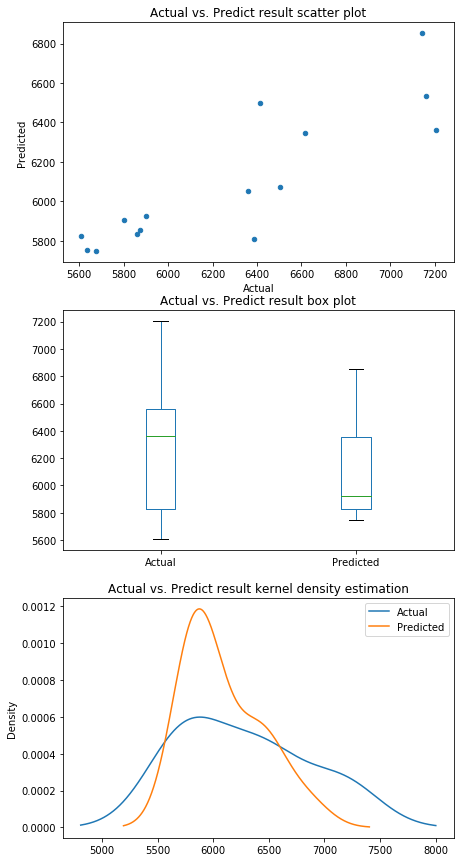

In [123]:
visualize_graph(df_pred_ANN_c)

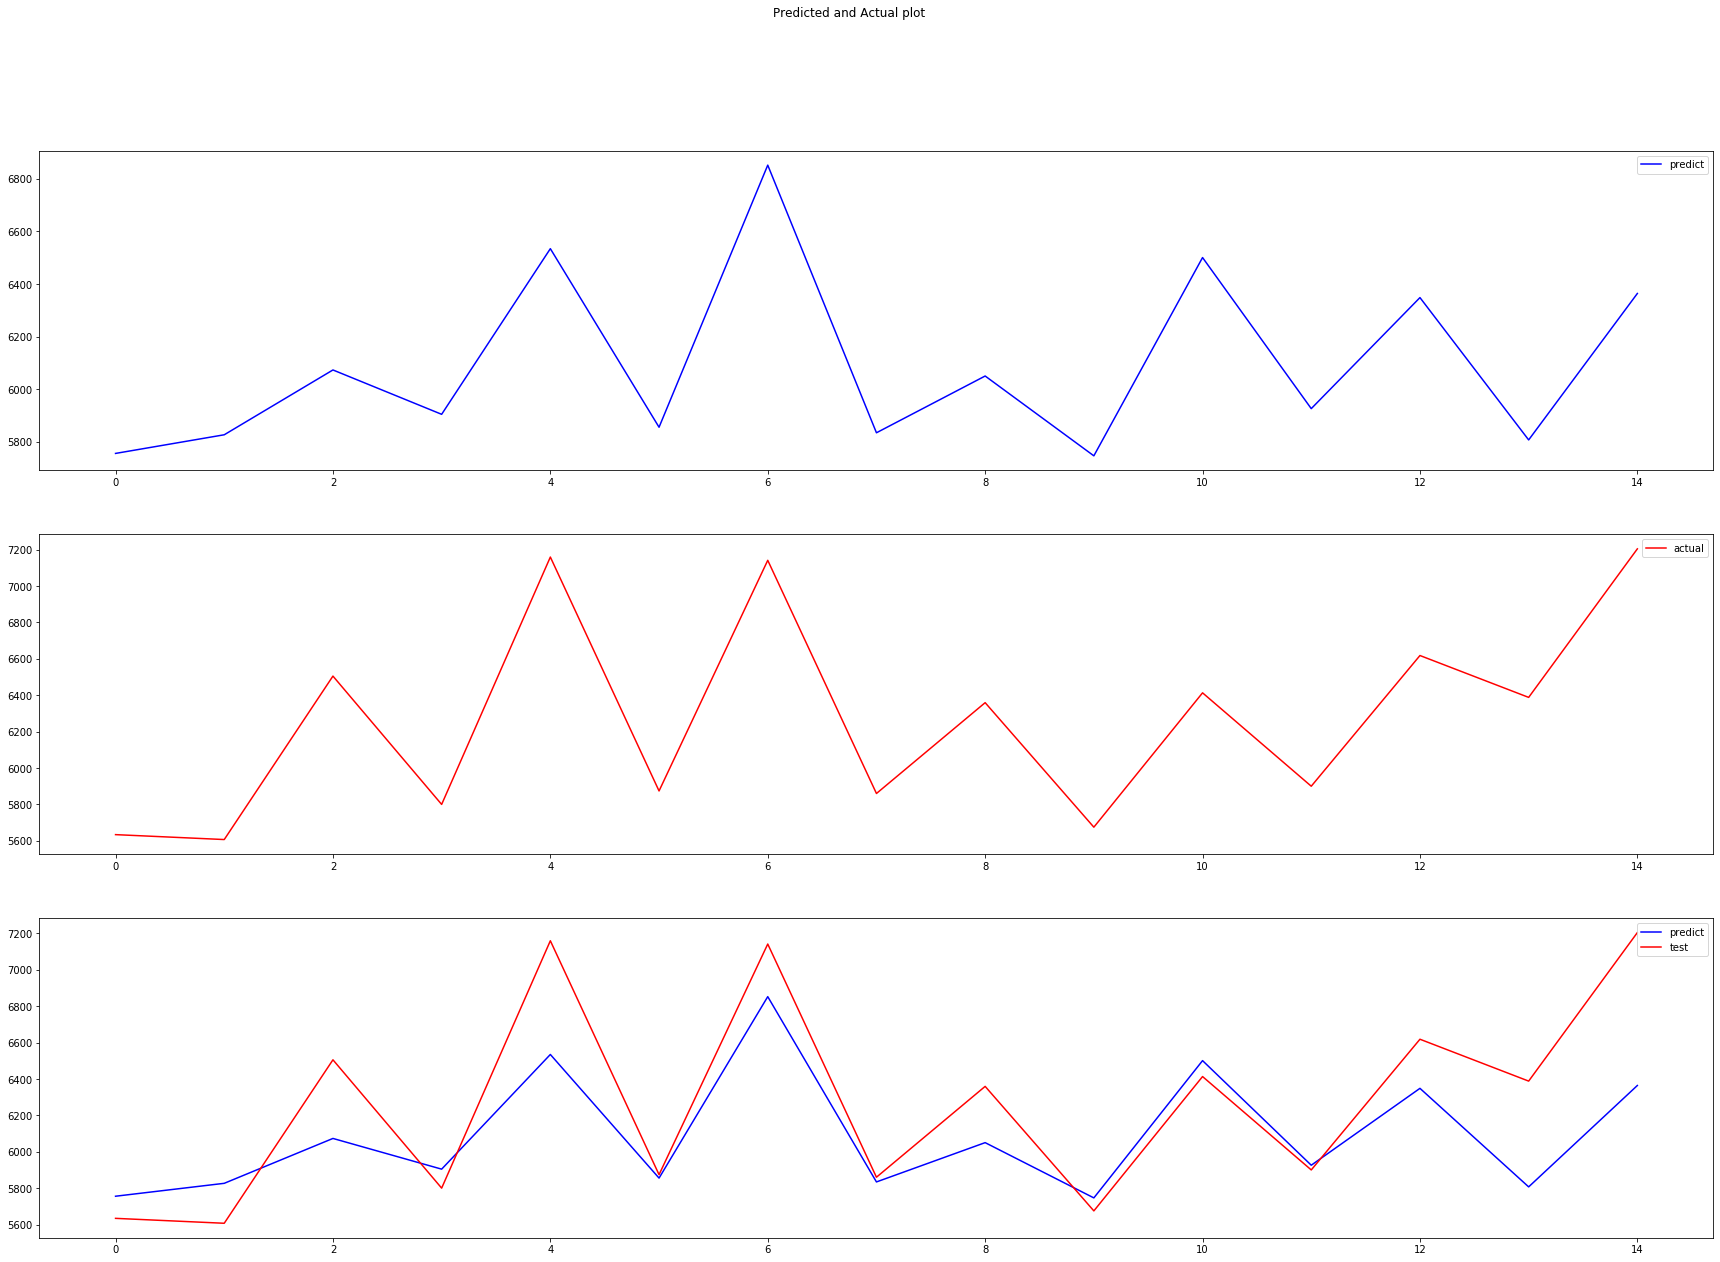

In [124]:
visualization(df_pred_ANN_c.Actual, df_pred_ANN_c.Predicted)

## Industrial Consumption Forecast

In [125]:
df_pred_i=sm_regression(X_train_i, y_train_i, X_test_i, y_test_i)

                            OLS Regression Results                            
Dep. Variable:       Industrial_Usage   R-squared:                       0.383
Model:                            OLS   Adj. R-squared:                  0.265
Method:                 Least Squares   F-statistic:                     3.243
Date:                Wed, 22 Jul 2020   Prob (F-statistic):            0.00386
Time:                        09:32:46   Log-Likelihood:                -336.95
No. Observations:                  57   AIC:                             693.9
Df Residuals:                      47   BIC:                             714.3
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    1

In [126]:
df_pred_i

,Actual,Predicted
83,1498,1513.664347
1183,1446,1486.428891
1683,1397,1520.708335
933,1564,1608.437461
1383,1461,1424.641946
3583,1307,1470.844075
1483,1501,1564.939947
3533,1411,1522.027303
2183,1625,1582.504363
1733,1476,1534.002691


In [127]:
evaluate_performances(df_pred_i['Actual'], df_pred_i['Predicted'])

Performance Evaluation
Mean Absolute Error: 74.17616709780393
Mean Squared Error: 9520.718428707518
Root Mean Squared Error: 97.57416885993709


# Industrial Feature Importance

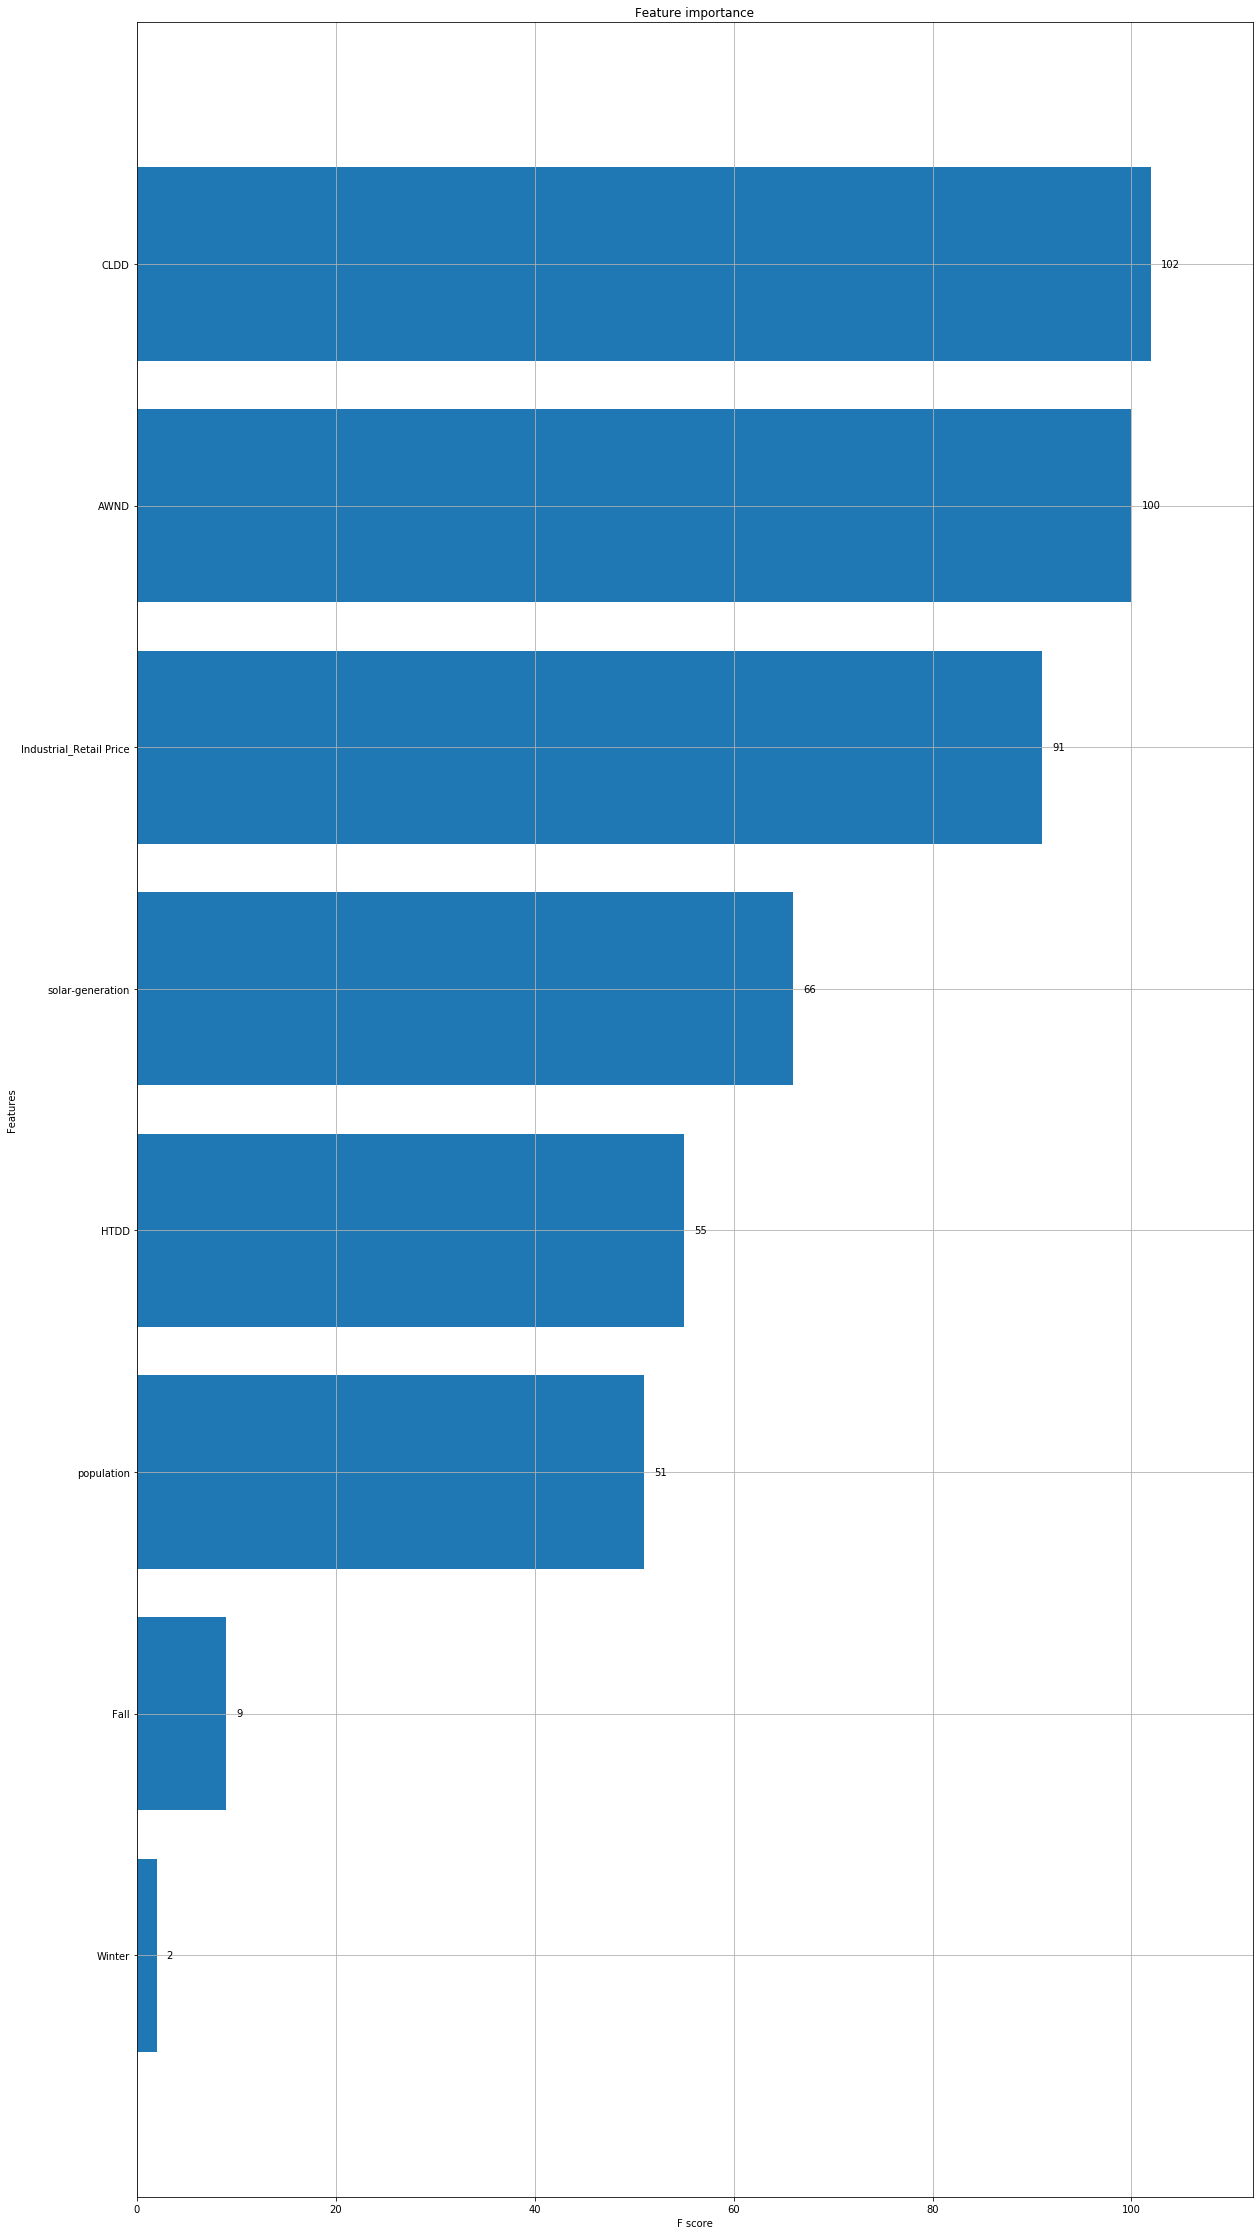

In [128]:
xgbRegressor = XGBRegressor(objective ='reg:squarederror')
xgbRegressor.fit(X_train_i, y_train_i)

fig, ax = plt.subplots(figsize=(20,40))
xgb.plot_importance(xgbRegressor, height=0.8, ax=ax)

C:\Users\Maggie\Anaconda3\envs\tensorflow_env\lib\site-packages\seaborn\axisgrid.py:2079: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


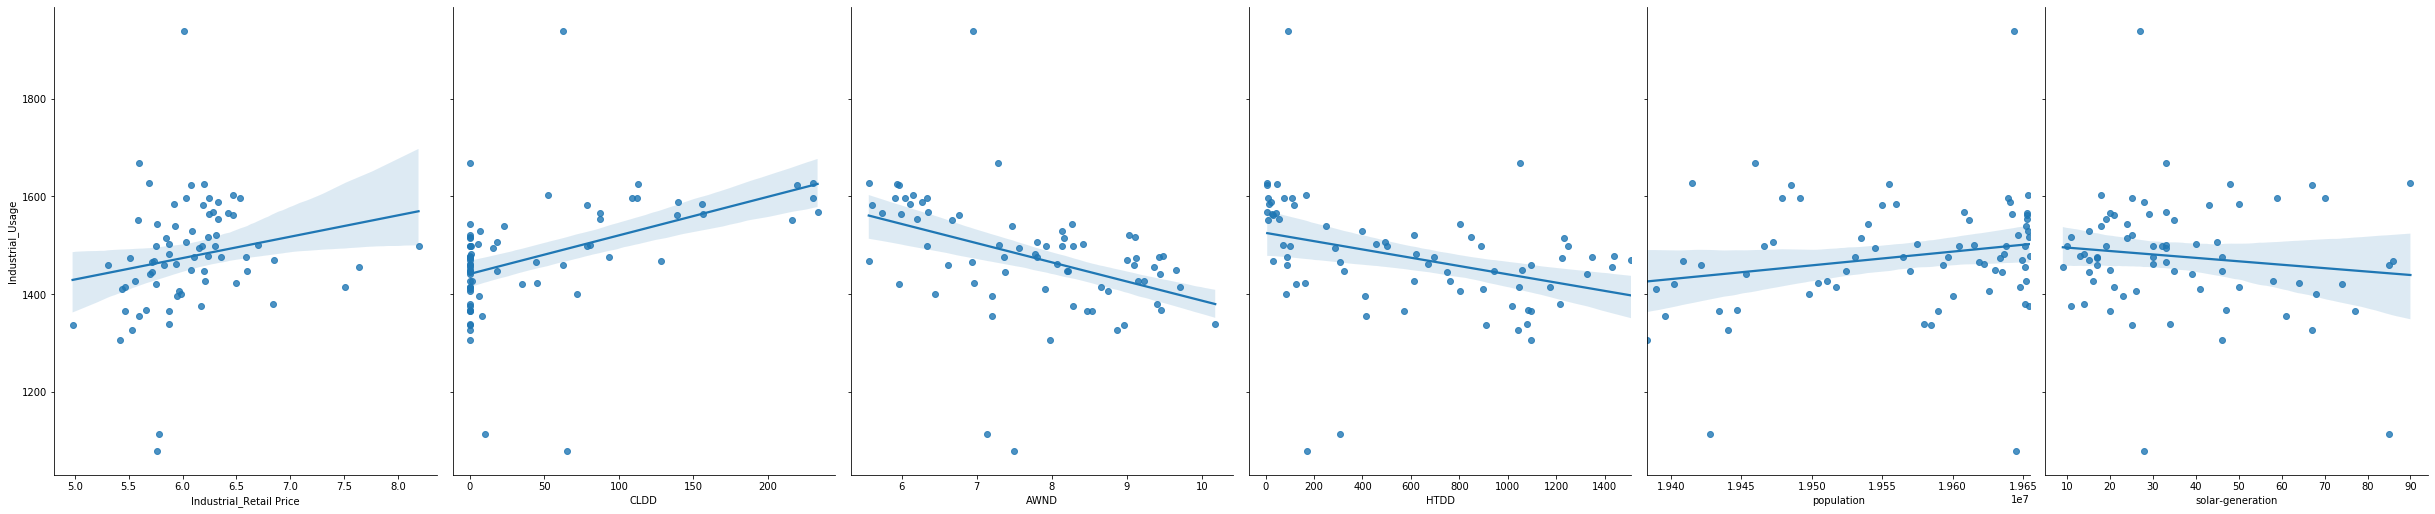

In [129]:
# Correlation Analysis
correlation_analysis(data_NY, industrial_numeric_columns_adj, ['Industrial_Usage'])

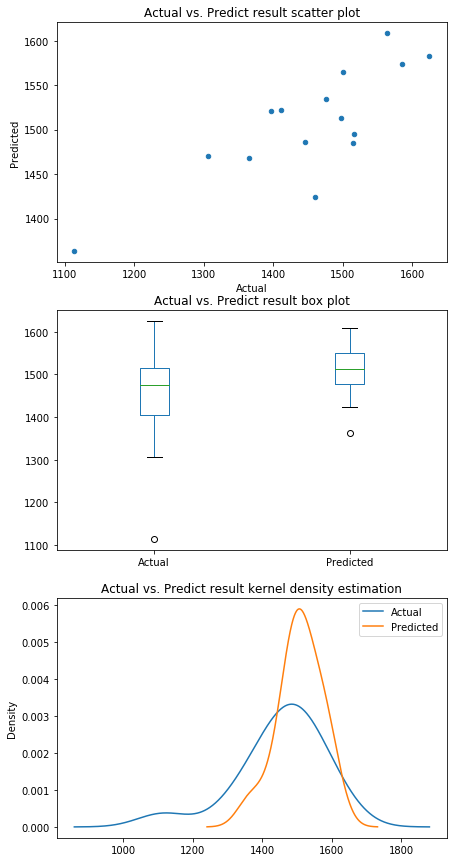

In [130]:
visualize_graph(df_pred_i)

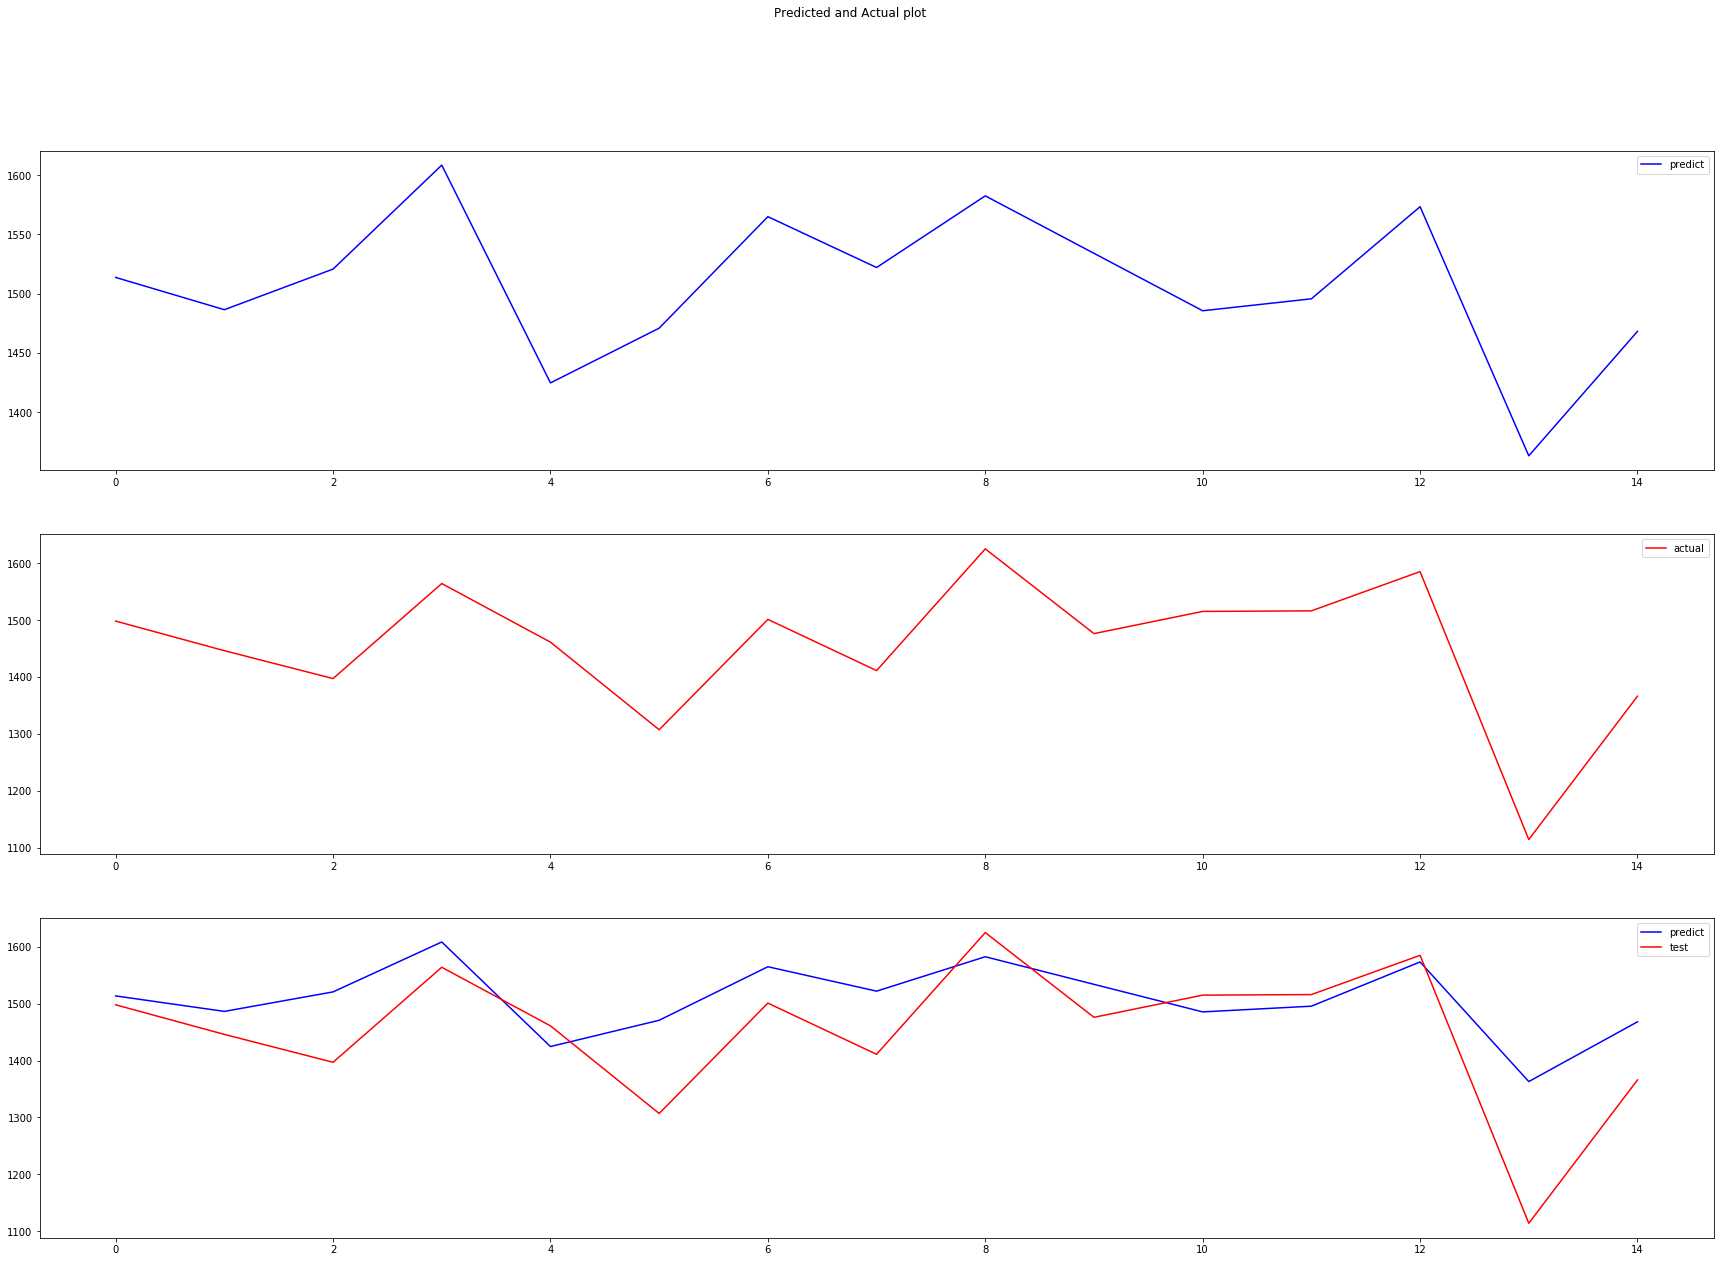

In [131]:
visualization(df_pred_i.Actual, df_pred_i.Predicted)

### Industrial_ANN

In [132]:
features_ANN_i=['Year', 'Month', 'Industrial_Usage', 'CLDD', 'AWND', 'HTDD', 'population', 'solar-generation','Summer', 'Fall', 'Winter', 'Industrial_Retail Price']
#Spring is the seasonal feature baseline
data_NY_ANN=data[data.NY==1]
data_NY_ANN=data_NY_ANN[features_ANN_i]
data_NY_ANN

,Year,Month,Industrial_Usage,CLDD,AWND,HTDD,population,solar-generation,Summer,Fall,Winter,Industrial_Retail Price
33,2014,1,1455,0.000000,9.366667,1430.557143,19651049,9,0,0,1,7.64
83,2014,2,1498,0.000000,8.280645,1248.608696,19651350,10,0,0,1,8.19
133,2014,3,1379,0.000000,9.403226,1216.255319,19651652,14,0,0,0,6.84
183,2014,4,1427,1.637681,9.145161,612.123188,19651953,16,0,0,0,6.21
233,2014,5,1539,22.702899,7.474194,250.637681,19652255,18,0,0,0,5.93
...,...,...,...,...,...,...,...,...,...,...,...,...
3383,2019,8,1468,128.261539,5.568750,30.107692,19408767,86,1,0,0,5.74
3433,2019,9,1420,35.213235,5.963333,125.595588,19402368,74,0,1,0,5.75
3483,2019,10,1355,7.858209,7.200000,414.216418,19395969,61,0,1,0,5.60
3533,2019,11,1411,0.000000,7.906250,898.641221,19389569,41,0,1,0,5.44


In [133]:
train_ANN, test_ANN = train_test_split(data_NY_ANN, test_size=0.2)
X_train_ANN_i, y_train_ANN_i = x_y_split(train_ANN, 'Industrial_Usage', ['Industrial_Usage'])
X_test_ANN_i,y_test_ANN_i = x_y_split(test_ANN, 'Industrial_Usage', ['Industrial_Usage'])

In [134]:
X_train_ANN_i, X_test_ANN_i = minmax_scaler(X_train_ANN_i, X_test_ANN_i, industrial_numeric_columns_adj)
y_train_ANN_i = (y_train_ANN_i - min(y_train_ANN_i))/(max(y_train_ANN_i) - min(y_train_ANN_i))

In [135]:
# Initialising the ANN
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 15, kernel_initializer = 'uniform', activation = 'relu', input_dim = 11))

# Adding the second hidden layer
classifier.add(Dense(units = 10, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mae'])

# Fitting the ANN to the training set
classifier.fit(X_train_ANN_i, y_train_ANN_i, validation_split = 0.2, batch_size = 10, epochs = 1200)

Train on 45 samples, validate on 12 samples
Epoch 1/1200
45/45 [==============================] - 1s 21ms/step - loss: 0.0597 - mae: 0.2086 - val_loss: 0.0541 - val_mae: 0.1770
Epoch 2/1200
45/45 [==============================] - 0s 488us/step - loss: 0.0378 - mae: 0.1530 - val_loss: 0.0483 - val_mae: 0.1643
Epoch 3/1200
45/45 [==============================] - 0s 466us/step - loss: 0.0301 - mae: 0.1247 - val_loss: 0.0503 - val_mae: 0.1711
Epoch 4/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0285 - mae: 0.1203 - val_loss: 0.0538 - val_mae: 0.1759
Epoch 5/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0298 - mae: 0.1228 - val_loss: 0.0548 - val_mae: 0.1769
Epoch 6/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0293 - mae: 0.1222 - val_loss: 0.0522 - val_mae: 0.1740
Epoch 7/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0281 - mae: 0.1193 - val_loss: 0.0500 - val_mae: 0.1705
Epoch 8/1200
45/45 

45/45 [==============================] - 0s 488us/step - loss: 0.0282 - mae: 0.1192 - val_loss: 0.0489 - val_mae: 0.1678
Epoch 62/1200
45/45 [==============================] - 0s 466us/step - loss: 0.0283 - mae: 0.1198 - val_loss: 0.0489 - val_mae: 0.1679
Epoch 63/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0283 - mae: 0.1194 - val_loss: 0.0495 - val_mae: 0.1694
Epoch 64/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0284 - mae: 0.1191 - val_loss: 0.0501 - val_mae: 0.1704
Epoch 65/1200
45/45 [==============================] - 0s 421us/step - loss: 0.0283 - mae: 0.1196 - val_loss: 0.0493 - val_mae: 0.1690
Epoch 66/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0283 - mae: 0.1196 - val_loss: 0.0492 - val_mae: 0.1687
Epoch 67/1200
45/45 [==============================] - 0s 466us/step - loss: 0.0283 - mae: 0.1194 - val_loss: 0.0494 - val_mae: 0.1690
Epoch 68/1200
45/45 [==============================] - 0s 488us/step 

45/45 [==============================] - 0s 465us/step - loss: 0.0280 - mae: 0.1181 - val_loss: 0.0504 - val_mae: 0.1705
Epoch 122/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0281 - mae: 0.1184 - val_loss: 0.0502 - val_mae: 0.1702
Epoch 123/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0280 - mae: 0.1181 - val_loss: 0.0498 - val_mae: 0.1695
Epoch 124/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0279 - mae: 0.1180 - val_loss: 0.0491 - val_mae: 0.1683
Epoch 125/1200
45/45 [==============================] - 0s 488us/step - loss: 0.0282 - mae: 0.1191 - val_loss: 0.0483 - val_mae: 0.1662
Epoch 126/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0281 - mae: 0.1191 - val_loss: 0.0485 - val_mae: 0.1669
Epoch 127/1200
45/45 [==============================] - 0s 488us/step - loss: 0.0280 - mae: 0.1182 - val_loss: 0.0494 - val_mae: 0.1687
Epoch 128/1200
45/45 [==============================] - 0s 465u

Epoch 181/1200
45/45 [==============================] - 0s 532us/step - loss: 0.0278 - mae: 0.1179 - val_loss: 0.0479 - val_mae: 0.1653
Epoch 182/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0278 - mae: 0.1180 - val_loss: 0.0480 - val_mae: 0.1654
Epoch 183/1200
45/45 [==============================] - 0s 554us/step - loss: 0.0276 - mae: 0.1173 - val_loss: 0.0486 - val_mae: 0.1667
Epoch 184/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0277 - mae: 0.1170 - val_loss: 0.0494 - val_mae: 0.1682
Epoch 185/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0277 - mae: 0.1174 - val_loss: 0.0489 - val_mae: 0.1673
Epoch 186/1200
45/45 [==============================] - 0s 532us/step - loss: 0.0277 - mae: 0.1171 - val_loss: 0.0485 - val_mae: 0.1666
Epoch 187/1200
45/45 [==============================] - 0s 532us/step - loss: 0.0276 - mae: 0.1171 - val_loss: 0.0486 - val_mae: 0.1668
Epoch 188/1200
45/45 [==========================

45/45 [==============================] - 0s 510us/step - loss: 0.0270 - mae: 0.1150 - val_loss: 0.0473 - val_mae: 0.1632
Epoch 242/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0271 - mae: 0.1146 - val_loss: 0.0481 - val_mae: 0.1646
Epoch 243/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0271 - mae: 0.1151 - val_loss: 0.0476 - val_mae: 0.1637
Epoch 244/1200
45/45 [==============================] - 0s 488us/step - loss: 0.0271 - mae: 0.1156 - val_loss: 0.0479 - val_mae: 0.1642
Epoch 245/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0270 - mae: 0.1151 - val_loss: 0.0472 - val_mae: 0.1629
Epoch 246/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0270 - mae: 0.1148 - val_loss: 0.0466 - val_mae: 0.1617
Epoch 247/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0271 - mae: 0.1157 - val_loss: 0.0467 - val_mae: 0.1616
Epoch 248/1200
45/45 [==============================] - 0s 443u

45/45 [==============================] - 0s 465us/step - loss: 0.0252 - mae: 0.1097 - val_loss: 0.0427 - val_mae: 0.1500
Epoch 302/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0264 - mae: 0.1152 - val_loss: 0.0431 - val_mae: 0.1512
Epoch 303/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0261 - mae: 0.1128 - val_loss: 0.0434 - val_mae: 0.1518
Epoch 304/1200
45/45 [==============================] - 0s 421us/step - loss: 0.0258 - mae: 0.1134 - val_loss: 0.0428 - val_mae: 0.1501
Epoch 305/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0257 - mae: 0.1127 - val_loss: 0.0442 - val_mae: 0.1534
Epoch 306/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0254 - mae: 0.1094 - val_loss: 0.0455 - val_mae: 0.1554
Epoch 307/1200
45/45 [==============================] - 0s 421us/step - loss: 0.0256 - mae: 0.1104 - val_loss: 0.0450 - val_mae: 0.1544
Epoch 308/1200
45/45 [==============================] - 0s 443u

45/45 [==============================] - 0s 443us/step - loss: 0.0250 - mae: 0.1099 - val_loss: 0.0388 - val_mae: 0.1391
Epoch 362/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0253 - mae: 0.1141 - val_loss: 0.0393 - val_mae: 0.1385
Epoch 363/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0247 - mae: 0.1058 - val_loss: 0.0446 - val_mae: 0.1496
Epoch 364/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0250 - mae: 0.1076 - val_loss: 0.0400 - val_mae: 0.1388
Epoch 365/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0241 - mae: 0.1090 - val_loss: 0.0386 - val_mae: 0.1363
Epoch 366/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0249 - mae: 0.1120 - val_loss: 0.0385 - val_mae: 0.1357
Epoch 367/1200
45/45 [==============================] - 0s 488us/step - loss: 0.0250 - mae: 0.1101 - val_loss: 0.0452 - val_mae: 0.1504
Epoch 368/1200
45/45 [==============================] - 0s 630u

45/45 [==============================] - 0s 598us/step - loss: 0.0239 - mae: 0.1063 - val_loss: 0.0377 - val_mae: 0.1304
Epoch 422/1200
45/45 [==============================] - 0s 620us/step - loss: 0.0236 - mae: 0.1104 - val_loss: 0.0351 - val_mae: 0.1301
Epoch 423/1200
45/45 [==============================] - 0s 554us/step - loss: 0.0242 - mae: 0.1136 - val_loss: 0.0368 - val_mae: 0.1286
Epoch 424/1200
45/45 [==============================] - 0s 576us/step - loss: 0.0239 - mae: 0.1046 - val_loss: 0.0429 - val_mae: 0.1421
Epoch 425/1200
45/45 [==============================] - 0s 620us/step - loss: 0.0242 - mae: 0.1067 - val_loss: 0.0370 - val_mae: 0.1294
Epoch 426/1200
45/45 [==============================] - 0s 554us/step - loss: 0.0234 - mae: 0.1064 - val_loss: 0.0357 - val_mae: 0.1283
Epoch 427/1200
45/45 [==============================] - 0s 532us/step - loss: 0.0233 - mae: 0.1042 - val_loss: 0.0377 - val_mae: 0.1302
Epoch 428/1200
45/45 [==============================] - 0s 488u

45/45 [==============================] - 0s 465us/step - loss: 0.0218 - mae: 0.1017 - val_loss: 0.0345 - val_mae: 0.1212
Epoch 482/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0217 - mae: 0.1012 - val_loss: 0.0338 - val_mae: 0.1202
Epoch 483/1200
45/45 [==============================] - 0s 488us/step - loss: 0.0220 - mae: 0.1011 - val_loss: 0.0331 - val_mae: 0.1206
Epoch 484/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0217 - mae: 0.1032 - val_loss: 0.0327 - val_mae: 0.1204
Epoch 485/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0214 - mae: 0.1022 - val_loss: 0.0330 - val_mae: 0.1208
Epoch 486/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0219 - mae: 0.1026 - val_loss: 0.0346 - val_mae: 0.1230
Epoch 487/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0217 - mae: 0.1007 - val_loss: 0.0344 - val_mae: 0.1227
Epoch 488/1200
45/45 [==============================] - 0s 532u

45/45 [==============================] - 0s 532us/step - loss: 0.0226 - mae: 0.0991 - val_loss: 0.0322 - val_mae: 0.1158
Epoch 542/1200
45/45 [==============================] - 0s 488us/step - loss: 0.0257 - mae: 0.1172 - val_loss: 0.0372 - val_mae: 0.1361
Epoch 543/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0253 - mae: 0.1139 - val_loss: 0.0384 - val_mae: 0.1306
Epoch 544/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0231 - mae: 0.1000 - val_loss: 0.0356 - val_mae: 0.1237
Epoch 545/1200
45/45 [==============================] - 0s 488us/step - loss: 0.0224 - mae: 0.1064 - val_loss: 0.0341 - val_mae: 0.1271
Epoch 546/1200
45/45 [==============================] - 0s 532us/step - loss: 0.0226 - mae: 0.1088 - val_loss: 0.0348 - val_mae: 0.1196
Epoch 547/1200
45/45 [==============================] - 0s 488us/step - loss: 0.0243 - mae: 0.1069 - val_loss: 0.0389 - val_mae: 0.1268
Epoch 548/1200
45/45 [==============================] - 0s 488u

45/45 [==============================] - 0s 421us/step - loss: 0.0211 - mae: 0.0967 - val_loss: 0.0338 - val_mae: 0.1188
Epoch 602/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0209 - mae: 0.0985 - val_loss: 0.0329 - val_mae: 0.1168
Epoch 603/1200
45/45 [==============================] - ETA: 0s - loss: 0.0074 - mae: 0.065 - 0s 532us/step - loss: 0.0204 - mae: 0.0957 - val_loss: 0.0334 - val_mae: 0.1160
Epoch 604/1200
45/45 [==============================] - 0s 488us/step - loss: 0.0219 - mae: 0.0976 - val_loss: 0.0315 - val_mae: 0.1126
Epoch 605/1200
45/45 [==============================] - 0s 532us/step - loss: 0.0217 - mae: 0.1019 - val_loss: 0.0305 - val_mae: 0.1147
Epoch 606/1200
45/45 [==============================] - 0s 488us/step - loss: 0.0220 - mae: 0.1050 - val_loss: 0.0324 - val_mae: 0.1123
Epoch 607/1200
45/45 [==============================] - 0s 532us/step - loss: 0.0218 - mae: 0.0972 - val_loss: 0.0316 - val_mae: 0.1132
Epoch 608/1200
45/45 [===

45/45 [==============================] - 0s 488us/step - loss: 0.0235 - mae: 0.0995 - val_loss: 0.0323 - val_mae: 0.1207
Epoch 662/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0227 - mae: 0.1088 - val_loss: 0.0330 - val_mae: 0.1230
Epoch 663/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0214 - mae: 0.1038 - val_loss: 0.0359 - val_mae: 0.1225
Epoch 664/1200
45/45 [==============================] - 0s 421us/step - loss: 0.0238 - mae: 0.0999 - val_loss: 0.0368 - val_mae: 0.1240
Epoch 665/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0222 - mae: 0.1032 - val_loss: 0.0314 - val_mae: 0.1188
Epoch 666/1200
45/45 [==============================] - 0s 488us/step - loss: 0.0221 - mae: 0.1061 - val_loss: 0.0317 - val_mae: 0.1172
Epoch 667/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0216 - mae: 0.1008 - val_loss: 0.0335 - val_mae: 0.1205
Epoch 668/1200
45/45 [==============================] - 0s 465u

45/45 [==============================] - 0s 465us/step - loss: 0.0205 - mae: 0.0967 - val_loss: 0.0309 - val_mae: 0.1115
Epoch 722/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0211 - mae: 0.1012 - val_loss: 0.0291 - val_mae: 0.1080
Epoch 723/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0204 - mae: 0.0982 - val_loss: 0.0300 - val_mae: 0.1098
Epoch 724/1200
45/45 [==============================] - 0s 709us/step - loss: 0.0205 - mae: 0.0956 - val_loss: 0.0321 - val_mae: 0.1136
Epoch 725/1200
45/45 [==============================] - 0s 488us/step - loss: 0.0208 - mae: 0.0967 - val_loss: 0.0317 - val_mae: 0.1129
Epoch 726/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0204 - mae: 0.0947 - val_loss: 0.0309 - val_mae: 0.1106
Epoch 727/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0205 - mae: 0.0961 - val_loss: 0.0304 - val_mae: 0.1107
Epoch 728/1200
45/45 [==============================] - 0s 532u

45/45 [==============================] - 0s 443us/step - loss: 0.0205 - mae: 0.0950 - val_loss: 0.0302 - val_mae: 0.1092
Epoch 782/1200
45/45 [==============================] - 0s 488us/step - loss: 0.0200 - mae: 0.0933 - val_loss: 0.0303 - val_mae: 0.1088
Epoch 783/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0200 - mae: 0.0936 - val_loss: 0.0302 - val_mae: 0.1091
Epoch 784/1200
45/45 [==============================] - 0s 488us/step - loss: 0.0199 - mae: 0.0939 - val_loss: 0.0295 - val_mae: 0.1072
Epoch 785/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0197 - mae: 0.0954 - val_loss: 0.0291 - val_mae: 0.1066
Epoch 786/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0210 - mae: 0.0975 - val_loss: 0.0284 - val_mae: 0.1050
Epoch 787/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0194 - mae: 0.0944 - val_loss: 0.0303 - val_mae: 0.1102
Epoch 788/1200
45/45 [==============================] - 0s 465u

45/45 [==============================] - 0s 510us/step - loss: 0.0200 - mae: 0.0930 - val_loss: 0.0305 - val_mae: 0.1081
Epoch 842/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0200 - mae: 0.0952 - val_loss: 0.0308 - val_mae: 0.1096
Epoch 843/1200
45/45 [==============================] - 0s 488us/step - loss: 0.0199 - mae: 0.0927 - val_loss: 0.0315 - val_mae: 0.1117
Epoch 844/1200
45/45 [==============================] - 0s 488us/step - loss: 0.0199 - mae: 0.0918 - val_loss: 0.0321 - val_mae: 0.1148
Epoch 845/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0204 - mae: 0.0941 - val_loss: 0.0298 - val_mae: 0.1075
Epoch 846/1200
45/45 [==============================] - 0s 621us/step - loss: 0.0195 - mae: 0.0927 - val_loss: 0.0293 - val_mae: 0.1080
Epoch 847/1200
45/45 [==============================] - 0s 576us/step - loss: 0.0204 - mae: 0.0952 - val_loss: 0.0278 - val_mae: 0.1023
Epoch 848/1200
45/45 [==============================] - 0s 532u

45/45 [==============================] - 0s 465us/step - loss: 0.0243 - mae: 0.1061 - val_loss: 0.0421 - val_mae: 0.1453
Epoch 902/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0246 - mae: 0.1058 - val_loss: 0.0422 - val_mae: 0.1456
Epoch 903/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0238 - mae: 0.1038 - val_loss: 0.0390 - val_mae: 0.1393
Epoch 904/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0241 - mae: 0.1083 - val_loss: 0.0371 - val_mae: 0.1363
Epoch 905/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0244 - mae: 0.1101 - val_loss: 0.0377 - val_mae: 0.1362
Epoch 906/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0241 - mae: 0.1050 - val_loss: 0.0396 - val_mae: 0.1399
Epoch 907/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0242 - mae: 0.1075 - val_loss: 0.0380 - val_mae: 0.1362
Epoch 908/1200
45/45 [==============================] - 0s 510u

45/45 [==============================] - 0s 465us/step - loss: 0.0229 - mae: 0.1095 - val_loss: 0.0330 - val_mae: 0.1182
Epoch 962/1200
45/45 [==============================] - 0s 488us/step - loss: 0.0223 - mae: 0.0999 - val_loss: 0.0388 - val_mae: 0.1331
Epoch 963/1200
45/45 [==============================] - 0s 532us/step - loss: 0.0218 - mae: 0.0969 - val_loss: 0.0315 - val_mae: 0.1159
Epoch 964/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0251 - mae: 0.1237 - val_loss: 0.0301 - val_mae: 0.1161
Epoch 965/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0228 - mae: 0.1035 - val_loss: 0.0405 - val_mae: 0.1367
Epoch 966/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0255 - mae: 0.1044 - val_loss: 0.0383 - val_mae: 0.1320
Epoch 967/1200
45/45 [==============================] - 0s 488us/step - loss: 0.0221 - mae: 0.1016 - val_loss: 0.0303 - val_mae: 0.1148
Epoch 968/1200
45/45 [==============================] - 0s 443u

45/45 [==============================] - 0s 488us/step - loss: 0.0220 - mae: 0.0968 - val_loss: 0.0323 - val_mae: 0.1145
Epoch 1022/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0211 - mae: 0.1024 - val_loss: 0.0279 - val_mae: 0.1058
Epoch 1023/1200
45/45 [==============================] - 0s 532us/step - loss: 0.0221 - mae: 0.1086 - val_loss: 0.0300 - val_mae: 0.1095
Epoch 1024/1200
45/45 [==============================] - 0s 488us/step - loss: 0.0229 - mae: 0.0942 - val_loss: 0.0362 - val_mae: 0.1245
Epoch 1025/1200
45/45 [==============================] - 0s 532us/step - loss: 0.0211 - mae: 0.0957 - val_loss: 0.0283 - val_mae: 0.1061
Epoch 1026/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0225 - mae: 0.1105 - val_loss: 0.0281 - val_mae: 0.1057
Epoch 1027/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0213 - mae: 0.1049 - val_loss: 0.0329 - val_mae: 0.1162
Epoch 1028/1200
45/45 [==============================] - 

45/45 [==============================] - 0s 643us/step - loss: 0.0212 - mae: 0.0968 - val_loss: 0.0316 - val_mae: 0.1115
Epoch 1081/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0215 - mae: 0.0950 - val_loss: 0.0310 - val_mae: 0.1099
Epoch 1082/1200
45/45 [==============================] - 0s 488us/step - loss: 0.0210 - mae: 0.0970 - val_loss: 0.0288 - val_mae: 0.1055
Epoch 1083/1200
45/45 [==============================] - 0s 554us/step - loss: 0.0210 - mae: 0.0996 - val_loss: 0.0272 - val_mae: 0.1010
Epoch 1084/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0219 - mae: 0.1073 - val_loss: 0.0267 - val_mae: 0.1004
Epoch 1085/1200
45/45 [==============================] - 0s 598us/step - loss: 0.0220 - mae: 0.0986 - val_loss: 0.0322 - val_mae: 0.1131
Epoch 1086/1200
45/45 [==============================] - ETA: 0s - loss: 0.0133 - mae: 0.076 - 0s 598us/step - loss: 0.0218 - mae: 0.0962 - val_loss: 0.0291 - val_mae: 0.1060
Epoch 1087/1200
45/

45/45 [==============================] - 0s 443us/step - loss: 0.0207 - mae: 0.0954 - val_loss: 0.0294 - val_mae: 0.1059
Epoch 1140/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0208 - mae: 0.0970 - val_loss: 0.0277 - val_mae: 0.1023
Epoch 1141/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0213 - mae: 0.0969 - val_loss: 0.0288 - val_mae: 0.1046
Epoch 1142/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0214 - mae: 0.0968 - val_loss: 0.0281 - val_mae: 0.1032
Epoch 1143/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0209 - mae: 0.0982 - val_loss: 0.0280 - val_mae: 0.1029
Epoch 1144/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0209 - mae: 0.0950 - val_loss: 0.0300 - val_mae: 0.1069
Epoch 1145/1200
45/45 [==============================] - 0s 421us/step - loss: 0.0212 - mae: 0.0941 - val_loss: 0.0288 - val_mae: 0.1046
Epoch 1146/1200
45/45 [==============================] - 

Epoch 1199/1200
45/45 [==============================] - 0s 488us/step - loss: 0.0206 - mae: 0.0939 - val_loss: 0.0311 - val_mae: 0.1097
Epoch 1200/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0221 - mae: 0.0943 - val_loss: 0.0300 - val_mae: 0.1070


In [136]:
# Predicting the Test set results
predictions_ANN_i = classifier.predict(X_test_ANN_i)
# Scale y back 
predictions_ANN_i = (predictions_ANN_i * (max(y_test_ANN_i) - min(y_test_ANN_i))) + min(y_test_ANN_i)
predictions_ANN_i = predictions_ANN_i.reshape(-1)
df_pred_ANN_i = pd.DataFrame({'Actual': y_test_ANN_i, 'Predicted': predictions_ANN_i})

In [137]:
df_pred_ANN_i

,Actual,Predicted
1833,1366,1692.229614
2783,1624,1816.604980
1283,1449,1693.680298
783,1520,1705.895264
1483,1501,1798.896729
683,1470,1709.537598
433,1603,1791.974365
333,1561,1816.330566
883,1938,1792.838135
2833,1596,1780.539673


In [138]:
evaluate_performances(y_test_ANN_i, predictions_ANN_i)

Performance Evaluation
Mean Absolute Error: 249.06249186197917
Mean Squared Error: 66243.7305064847
Root Mean Squared Error: 257.3785742956952


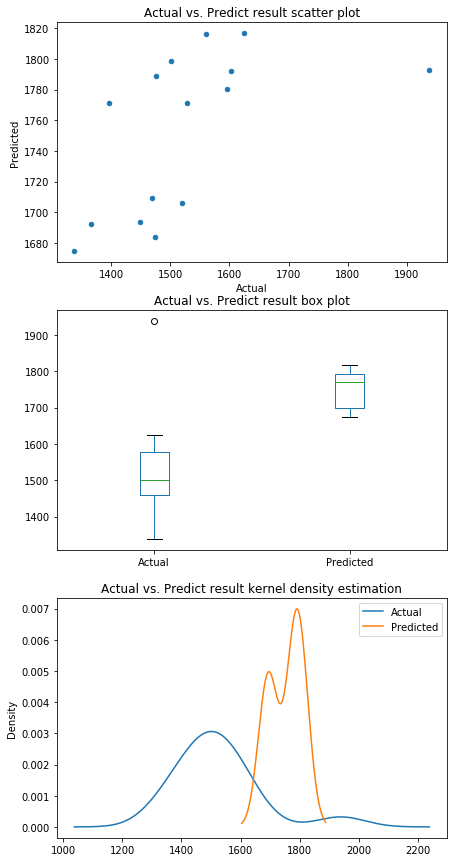

In [139]:
visualize_graph(df_pred_ANN_i)

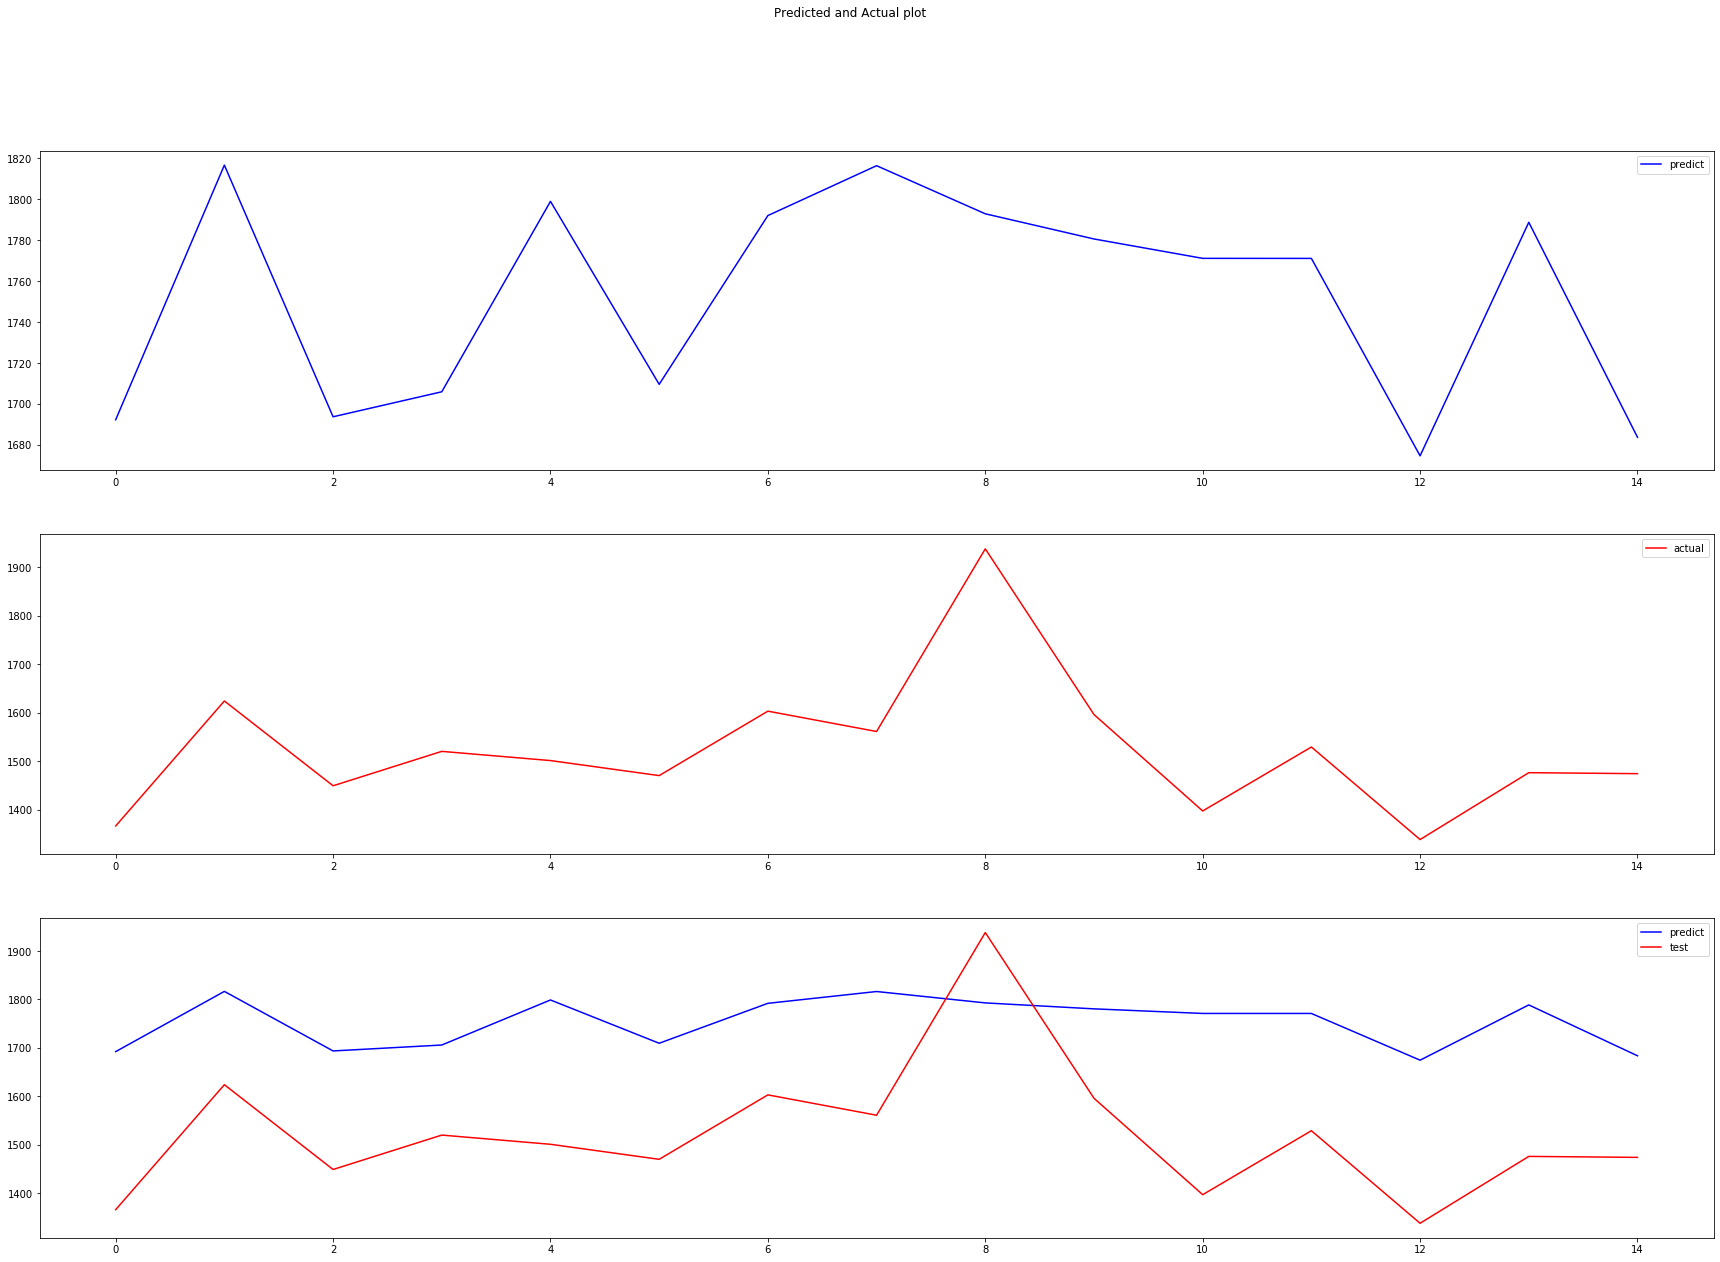

In [140]:
visualization(df_pred_ANN_i.Actual, df_pred_ANN_i.Predicted)

## Residential Consumption Forecast

In [56]:
df_pred_r=sm_regression(X_train_r, y_train_r, X_test_r, y_test_r)

                            OLS Regression Results                            
Dep. Variable:      Residential_Usage   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.796
Method:                 Least Squares   F-statistic:                     25.32
Date:                Wed, 22 Jul 2020   Prob (F-statistic):           3.75e-15
Time:                        06:32:28   Log-Likelihood:                -401.74
No. Observations:                  57   AIC:                             823.5
Df Residuals:                      47   BIC:                             843.9
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [57]:
df_pred_r

,Actual,Predicted
83,4550.0,4602.394244
1183,3979.0,4107.597219
1683,3717.0,3814.618160
933,4864.0,5081.792252
1383,3379.0,3707.240619
3583,4268.0,4247.588387
1483,4083.0,4071.033188
3533,3527.0,4047.169921
2183,5038.0,4633.789234
1733,3513.0,3979.011238


In [58]:
evaluate_performances(df_pred_r['Actual'], df_pred_r['Predicted'])

Performance Evaluation
Mean Absolute Error: 222.49860937422164
Mean Squared Error: 75358.0579075579
Root Mean Squared Error: 274.5142216854309


## Residential_Feature Importance

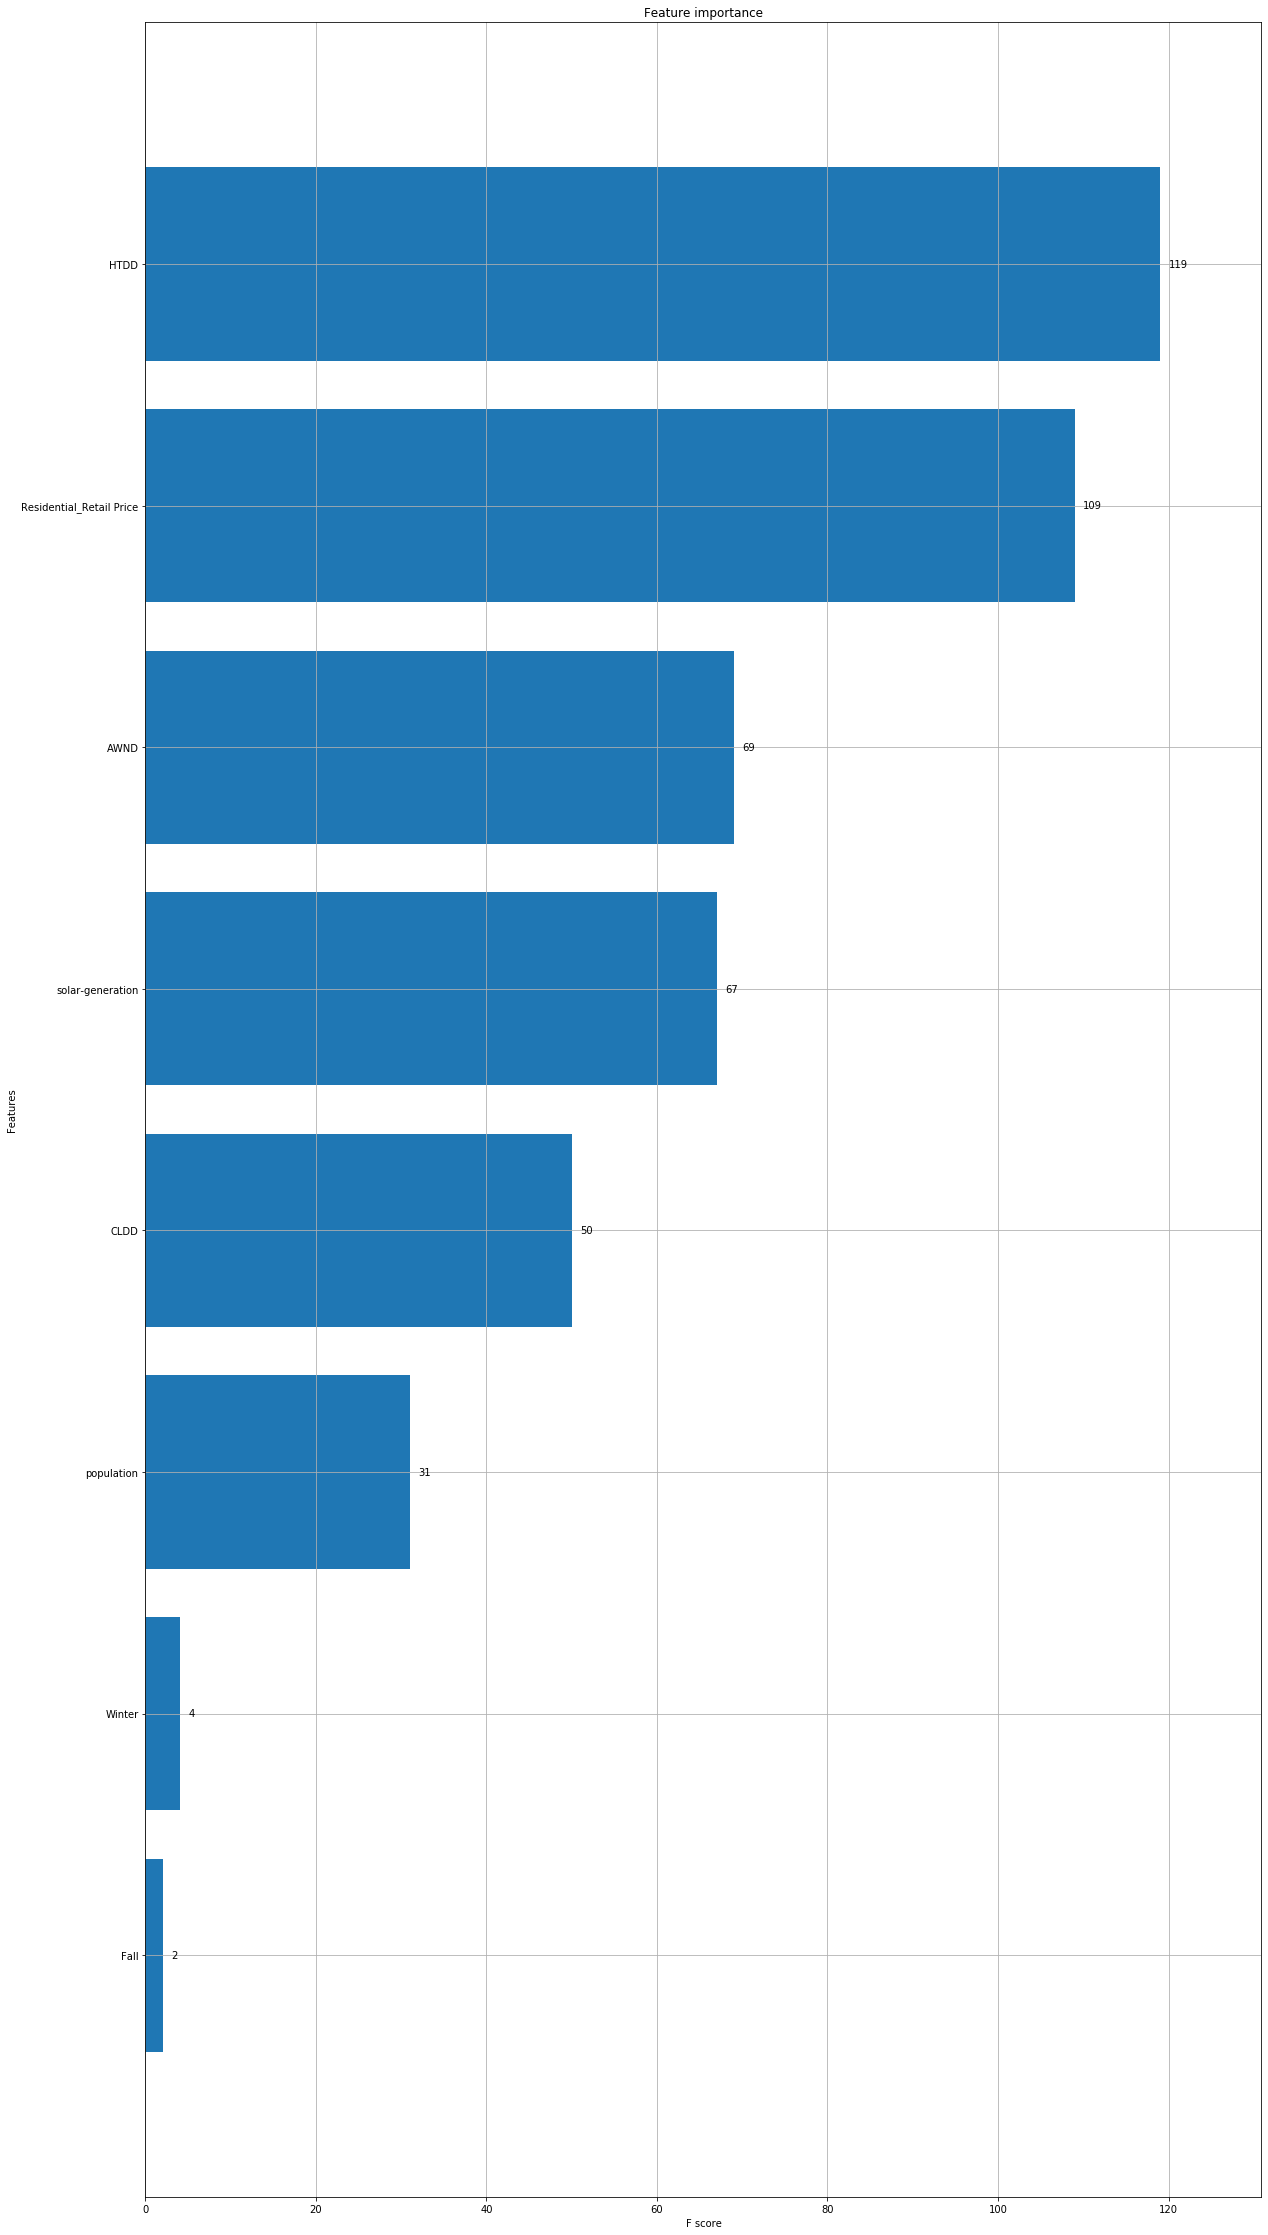

In [59]:
xgbRegressor = XGBRegressor(objective ='reg:squarederror')
xgbRegressor.fit(X_train_r, y_train_r)

fig, ax = plt.subplots(figsize=(20,40))
xgb.plot_importance(xgbRegressor, height=0.8, ax=ax)

C:\Users\Maggie\Anaconda3\envs\tensorflow_env\lib\site-packages\seaborn\axisgrid.py:2079: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


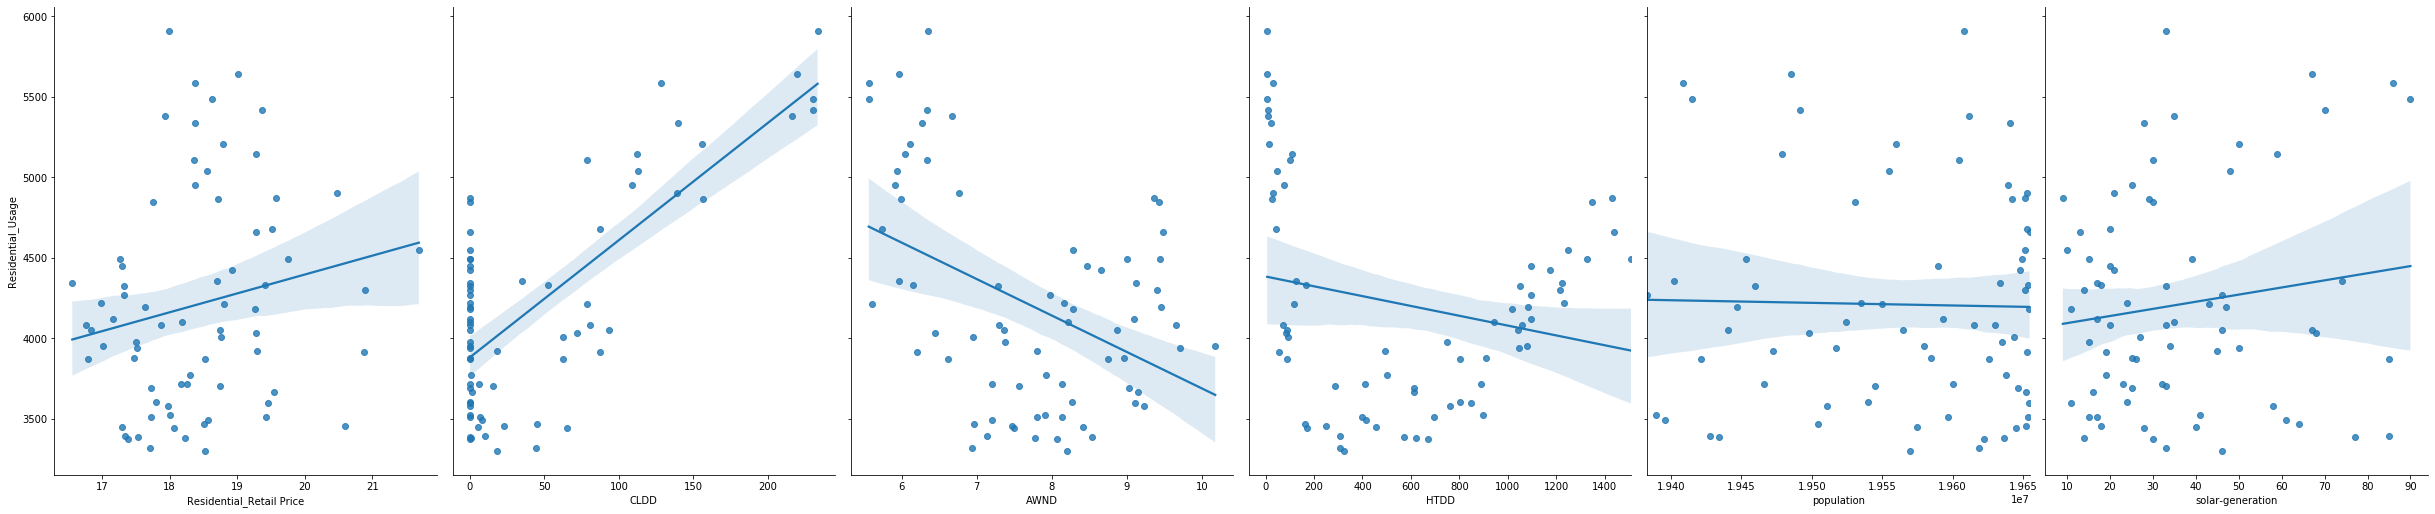

In [60]:
# Correlation Analysis
correlation_analysis(data_NY, residential_numeric_columns_adj, ['Residential_Usage'])

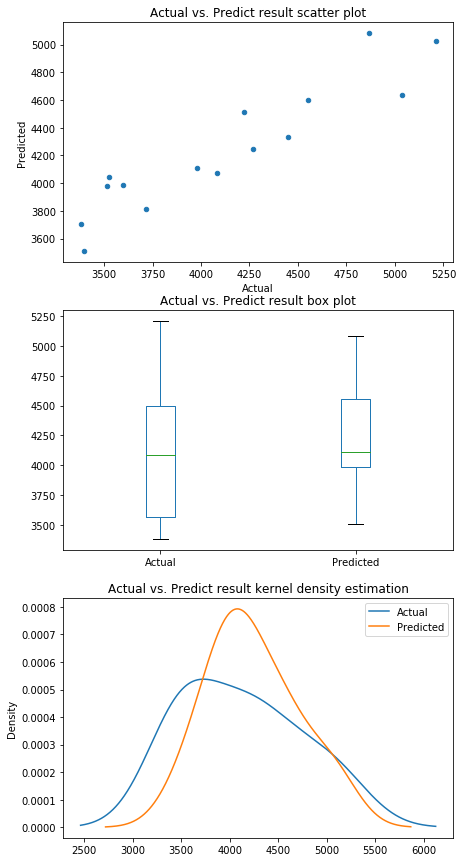

In [61]:
visualize_graph(df_pred_r)

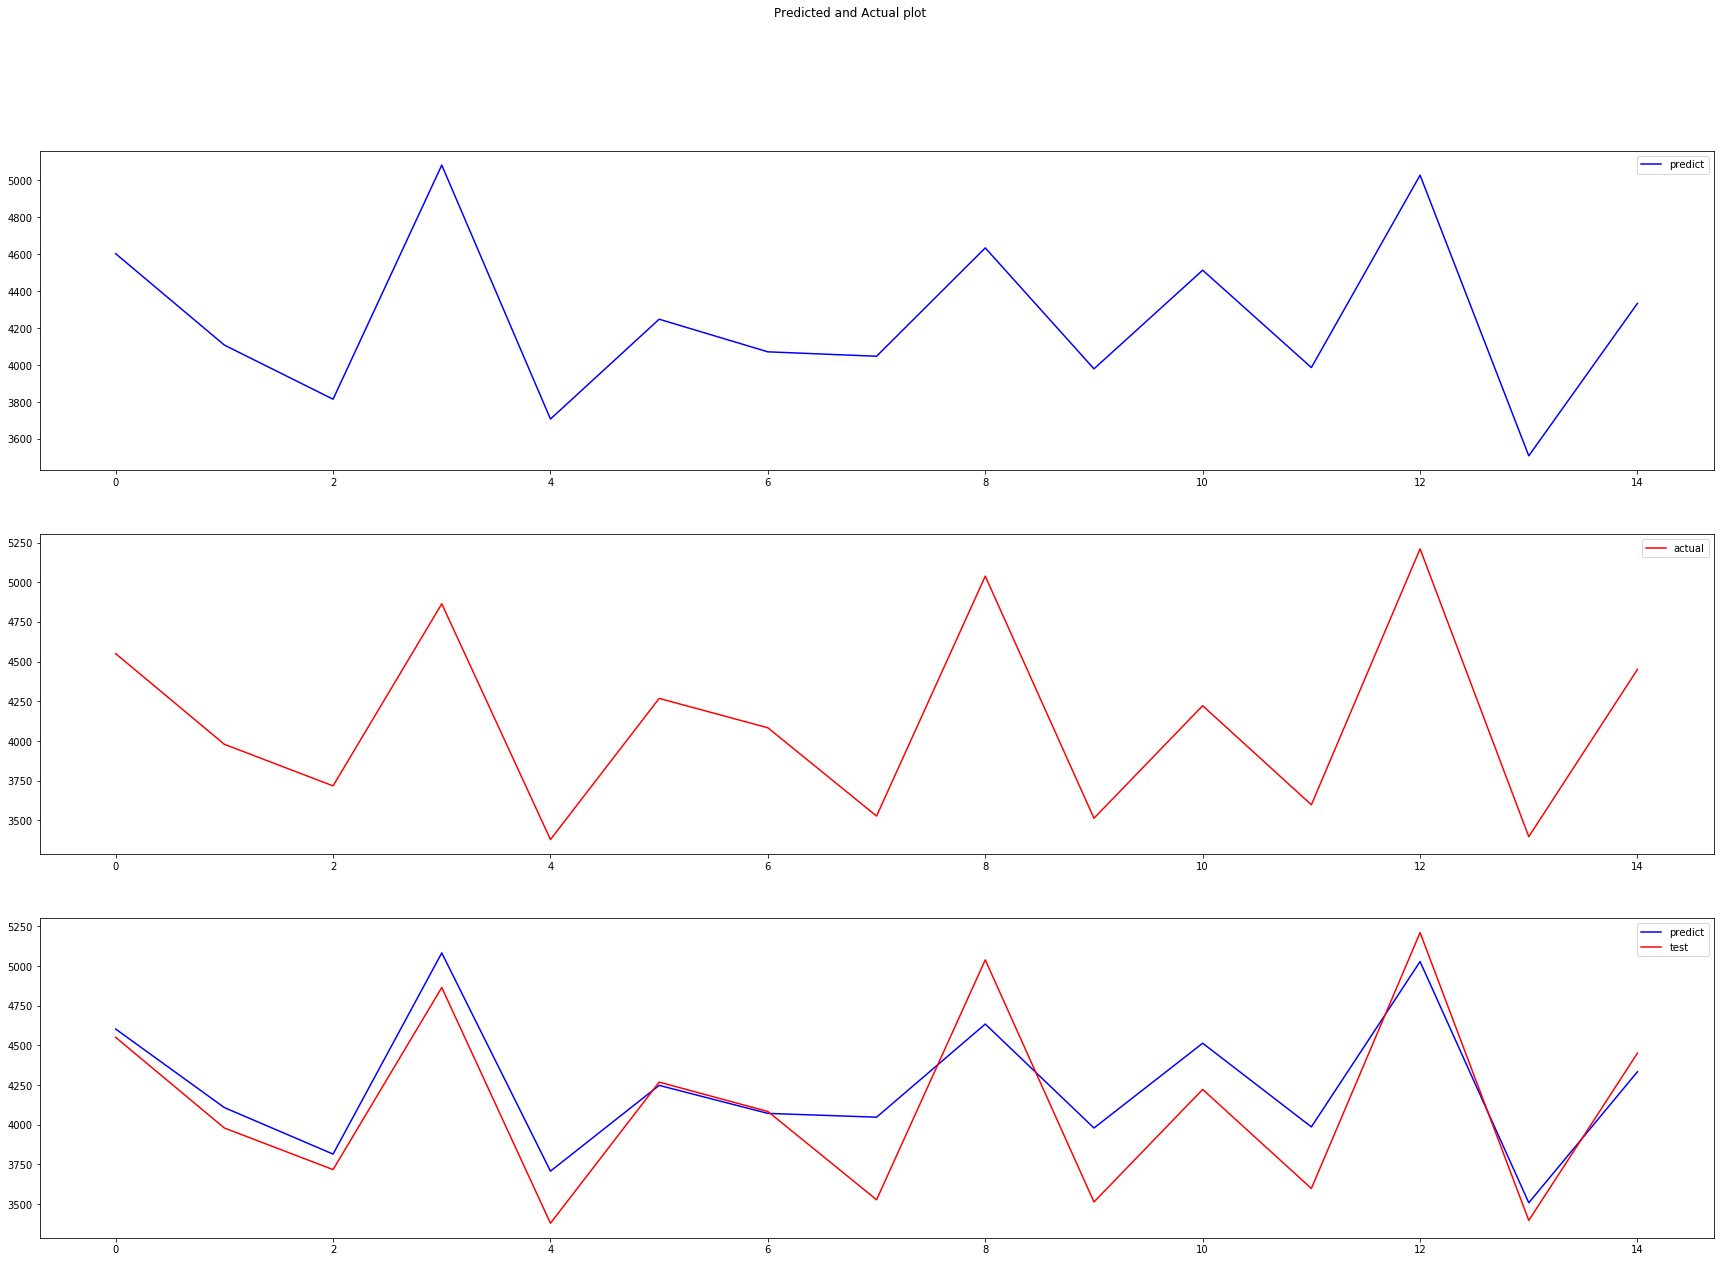

In [62]:
visualization(df_pred_r.Actual, df_pred_r.Predicted)

### Residential_ANN

In [63]:
features_ANN_r=['Year', 'Month', 'Residential_Usage', 'CLDD', 'AWND', 'HTDD', 'population', 'solar-generation','Summer', 'Fall', 'Winter', 'Residential_Retail Price']
#Spring is the seasonal feature baseline
data_NY_ANN=data[data.NY==1]
data_NY_ANN=data_NY_ANN[features_ANN_r]
data_NY_ANN


,Year,Month,Residential_Usage,CLDD,AWND,HTDD,population,solar-generation,Summer,Fall,Winter,Residential_Retail Price
33,2014,1,4871.0,0.000000,9.366667,1430.557143,19651049,9,0,0,1,19.57
83,2014,2,4550.0,0.000000,8.280645,1248.608696,19651350,10,0,0,1,21.69
133,2014,3,4301.0,0.000000,9.403226,1216.255319,19651652,14,0,0,0,20.90
183,2014,4,3669.0,1.637681,9.145161,612.123188,19651953,16,0,0,0,19.54
233,2014,5,3458.0,22.702899,7.474194,250.637681,19652255,18,0,0,0,20.59
...,...,...,...,...,...,...,...,...,...,...,...,...
3383,2019,8,5586.0,128.261539,5.568750,30.107692,19408767,86,1,0,0,18.37
3433,2019,9,4357.0,35.213235,5.963333,125.595588,19402368,74,0,1,0,18.70
3483,2019,10,3494.0,7.858209,7.200000,414.216418,19395969,61,0,1,0,18.57
3533,2019,11,3527.0,0.000000,7.906250,898.641221,19389569,41,0,1,0,18.00


In [64]:
train_ANN, test_ANN = train_test_split(data_NY_ANN, test_size=0.2)
X_train_ANN_r, y_train_ANN_r = x_y_split(train_ANN, 'Residential_Usage', ['Residential_Usage'])
X_test_ANN_r,y_test_ANN_r = x_y_split(test_ANN, 'Residential_Usage', ['Residential_Usage'])


In [65]:
X_train_ANN_r, X_test_ANN_r = minmax_scaler(X_train_ANN_r, X_test_ANN_r, residential_numeric_columns_adj)
y_train_ANN_r = (y_train_ANN_r - min(y_train_ANN_r))/(max(y_train_ANN_r) - min(y_train_ANN_r))


In [66]:
# Initialising the ANN
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 15, kernel_initializer = 'uniform', activation = 'relu', input_dim = 11))

# Adding the second hidden layer
# classifier.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the second hidden layer
classifier.add(Dense(units = 5, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mae'])

# Fitting the ANN to the training set
classifier.fit(X_train_ANN_r, y_train_ANN_r, validation_split = 0.2, batch_size = 10, epochs = 1200)


Train on 45 samples, validate on 12 samples
Epoch 1/1200
45/45 [==============================] - 1s 23ms/step - loss: 0.0869 - mae: 0.2634 - val_loss: 0.0655 - val_mae: 0.2152
Epoch 2/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0811 - mae: 0.2494 - val_loss: 0.0620 - val_mae: 0.2086
Epoch 3/1200
45/45 [==============================] - 0s 554us/step - loss: 0.0773 - mae: 0.2376 - val_loss: 0.0617 - val_mae: 0.2021
Epoch 4/1200
45/45 [==============================] - 0s 488us/step - loss: 0.0758 - mae: 0.2318 - val_loss: 0.0632 - val_mae: 0.1991
Epoch 5/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0777 - mae: 0.2274 - val_loss: 0.0651 - val_mae: 0.1991
Epoch 6/1200
45/45 [==============================] - 0s 533us/step - loss: 0.0774 - mae: 0.2264 - val_loss: 0.0639 - val_mae: 0.1991
Epoch 7/1200
45/45 [==============================] - 0s 576us/step - loss: 0.0770 - mae: 0.2294 - val_loss: 0.0624 - val_mae: 0.1994
Epoch 8/1200
45/45 

45/45 [==============================] - 0s 488us/step - loss: 0.0757 - mae: 0.2299 - val_loss: 0.0619 - val_mae: 0.2003
Epoch 62/1200
45/45 [==============================] - 0s 488us/step - loss: 0.0757 - mae: 0.2309 - val_loss: 0.0617 - val_mae: 0.2008
Epoch 63/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0756 - mae: 0.2312 - val_loss: 0.0617 - val_mae: 0.2011
Epoch 64/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0757 - mae: 0.2316 - val_loss: 0.0616 - val_mae: 0.2012
Epoch 65/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0755 - mae: 0.2317 - val_loss: 0.0614 - val_mae: 0.2022
Epoch 66/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0757 - mae: 0.2326 - val_loss: 0.0614 - val_mae: 0.2026
Epoch 67/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0769 - mae: 0.2356 - val_loss: 0.0612 - val_mae: 0.2044
Epoch 68/1200
45/45 [==============================] - 0s 465us/step 

45/45 [==============================] - 0s 465us/step - loss: 0.0756 - mae: 0.2270 - val_loss: 0.0628 - val_mae: 0.1988
Epoch 122/1200
45/45 [==============================] - 0s 488us/step - loss: 0.0753 - mae: 0.2282 - val_loss: 0.0618 - val_mae: 0.1996
Epoch 123/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0749 - mae: 0.2296 - val_loss: 0.0613 - val_mae: 0.2012
Epoch 124/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0749 - mae: 0.2310 - val_loss: 0.0611 - val_mae: 0.2022
Epoch 125/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0750 - mae: 0.2320 - val_loss: 0.0609 - val_mae: 0.2034
Epoch 126/1200
45/45 [==============================] - 0s 554us/step - loss: 0.0755 - mae: 0.2344 - val_loss: 0.0609 - val_mae: 0.2040
Epoch 127/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0758 - mae: 0.2352 - val_loss: 0.0609 - val_mae: 0.2037
Epoch 128/1200
45/45 [==============================] - 0s 443u

45/45 [==============================] - 0s 576us/step - loss: 0.0748 - mae: 0.2324 - val_loss: 0.0599 - val_mae: 0.2037
Epoch 182/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0736 - mae: 0.2323 - val_loss: 0.0600 - val_mae: 0.2015
Epoch 183/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0728 - mae: 0.2278 - val_loss: 0.0609 - val_mae: 0.1983
Epoch 184/1200
45/45 [==============================] - 0s 532us/step - loss: 0.0739 - mae: 0.2245 - val_loss: 0.0626 - val_mae: 0.1980
Epoch 185/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0737 - mae: 0.2240 - val_loss: 0.0614 - val_mae: 0.1979
Epoch 186/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0730 - mae: 0.2254 - val_loss: 0.0604 - val_mae: 0.1995
Epoch 187/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0734 - mae: 0.2275 - val_loss: 0.0603 - val_mae: 0.1995
Epoch 188/1200
45/45 [==============================] - 0s 532u

45/45 [==============================] - 0s 465us/step - loss: 0.0641 - mae: 0.2166 - val_loss: 0.0594 - val_mae: 0.1964
Epoch 242/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0646 - mae: 0.2097 - val_loss: 0.0562 - val_mae: 0.1932
Epoch 243/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0636 - mae: 0.2163 - val_loss: 0.0541 - val_mae: 0.1971
Epoch 244/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0649 - mae: 0.2154 - val_loss: 0.0611 - val_mae: 0.1985
Epoch 245/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0637 - mae: 0.2125 - val_loss: 0.0534 - val_mae: 0.1982
Epoch 246/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0608 - mae: 0.2131 - val_loss: 0.0547 - val_mae: 0.1932
Epoch 247/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0616 - mae: 0.2104 - val_loss: 0.0554 - val_mae: 0.1921
Epoch 248/1200
45/45 [==============================] - 0s 465u

45/45 [==============================] - 0s 466us/step - loss: 0.0471 - mae: 0.1862 - val_loss: 0.0602 - val_mae: 0.1958
Epoch 302/1200
45/45 [==============================] - 0s 487us/step - loss: 0.0516 - mae: 0.1860 - val_loss: 0.0510 - val_mae: 0.1914
Epoch 303/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0514 - mae: 0.1961 - val_loss: 0.0521 - val_mae: 0.1889
Epoch 304/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0454 - mae: 0.1821 - val_loss: 0.0584 - val_mae: 0.1940
Epoch 305/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0461 - mae: 0.1822 - val_loss: 0.0516 - val_mae: 0.1895
Epoch 306/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0490 - mae: 0.1898 - val_loss: 0.0541 - val_mae: 0.1905
Epoch 307/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0470 - mae: 0.1821 - val_loss: 0.0543 - val_mae: 0.1906
Epoch 308/1200
45/45 [==============================] - 0s 510u

45/45 [==============================] - 0s 488us/step - loss: 0.0435 - mae: 0.1774 - val_loss: 0.0505 - val_mae: 0.1817
Epoch 362/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0418 - mae: 0.1751 - val_loss: 0.0620 - val_mae: 0.1905
Epoch 363/1200
45/45 [==============================] - 0s 488us/step - loss: 0.0440 - mae: 0.1800 - val_loss: 0.0503 - val_mae: 0.1814
Epoch 364/1200
45/45 [==============================] - 0s 554us/step - loss: 0.0419 - mae: 0.1710 - val_loss: 0.0581 - val_mae: 0.1856
Epoch 365/1200
45/45 [==============================] - 0s 554us/step - loss: 0.0413 - mae: 0.1732 - val_loss: 0.0487 - val_mae: 0.1833
Epoch 366/1200
45/45 [==============================] - 0s 554us/step - loss: 0.0422 - mae: 0.1736 - val_loss: 0.0571 - val_mae: 0.1846
Epoch 367/1200
45/45 [==============================] - 0s 554us/step - loss: 0.0436 - mae: 0.1781 - val_loss: 0.0556 - val_mae: 0.1833
Epoch 368/1200
45/45 [==============================] - 0s 554u

Epoch 421/1200
45/45 [==============================] - 0s 532us/step - loss: 0.0393 - mae: 0.1667 - val_loss: 0.0498 - val_mae: 0.1726
Epoch 422/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0376 - mae: 0.1640 - val_loss: 0.0492 - val_mae: 0.1728
Epoch 423/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0372 - mae: 0.1631 - val_loss: 0.0511 - val_mae: 0.1733
Epoch 424/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0379 - mae: 0.1646 - val_loss: 0.0498 - val_mae: 0.1721
Epoch 425/1200
45/45 [==============================] - 0s 554us/step - loss: 0.0393 - mae: 0.1678 - val_loss: 0.0492 - val_mae: 0.1723
Epoch 426/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0423 - mae: 0.1757 - val_loss: 0.0491 - val_mae: 0.1721
Epoch 427/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0389 - mae: 0.1639 - val_loss: 0.0507 - val_mae: 0.1724
Epoch 428/1200
45/45 [==========================

45/45 [==============================] - 0s 488us/step - loss: 0.0394 - mae: 0.1701 - val_loss: 0.0468 - val_mae: 0.1650
Epoch 482/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0351 - mae: 0.1583 - val_loss: 0.0506 - val_mae: 0.1686
Epoch 483/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0401 - mae: 0.1696 - val_loss: 0.0462 - val_mae: 0.1650
Epoch 484/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0350 - mae: 0.1586 - val_loss: 0.0512 - val_mae: 0.1696
Epoch 485/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0392 - mae: 0.1685 - val_loss: 0.0460 - val_mae: 0.1648
Epoch 486/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0397 - mae: 0.1694 - val_loss: 0.0472 - val_mae: 0.1643
Epoch 487/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0354 - mae: 0.1580 - val_loss: 0.0439 - val_mae: 0.1663
Epoch 488/1200
45/45 [==============================] - 0s 488u

45/45 [==============================] - 0s 465us/step - loss: 0.0343 - mae: 0.1566 - val_loss: 0.0548 - val_mae: 0.1749
Epoch 542/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0388 - mae: 0.1610 - val_loss: 0.0411 - val_mae: 0.1663
Epoch 543/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0434 - mae: 0.1777 - val_loss: 0.0411 - val_mae: 0.1643
Epoch 544/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0401 - mae: 0.1632 - val_loss: 0.0557 - val_mae: 0.1763
Epoch 545/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0326 - mae: 0.1553 - val_loss: 0.0434 - val_mae: 0.1764
Epoch 546/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0425 - mae: 0.1761 - val_loss: 0.0457 - val_mae: 0.1578
Epoch 547/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0478 - mae: 0.1767 - val_loss: 0.0473 - val_mae: 0.1597
Epoch 548/1200
45/45 [==============================] - 0s 465u

45/45 [==============================] - 0s 576us/step - loss: 0.0351 - mae: 0.1529 - val_loss: 0.0397 - val_mae: 0.1563
Epoch 602/1200
45/45 [==============================] - 0s 532us/step - loss: 0.0335 - mae: 0.1539 - val_loss: 0.0452 - val_mae: 0.1547
Epoch 603/1200
45/45 [==============================] - 0s 665us/step - loss: 0.0326 - mae: 0.1494 - val_loss: 0.0436 - val_mae: 0.1526
Epoch 604/1200
45/45 [==============================] - 0s 576us/step - loss: 0.0319 - mae: 0.1492 - val_loss: 0.0428 - val_mae: 0.1519
Epoch 605/1200
45/45 [==============================] - 0s 576us/step - loss: 0.0316 - mae: 0.1497 - val_loss: 0.0407 - val_mae: 0.1515
Epoch 606/1200
45/45 [==============================] - 0s 576us/step - loss: 0.0322 - mae: 0.1517 - val_loss: 0.0421 - val_mae: 0.1511
Epoch 607/1200
45/45 [==============================] - 0s 532us/step - loss: 0.0403 - mae: 0.1712 - val_loss: 0.0394 - val_mae: 0.1558
Epoch 608/1200
45/45 [==============================] - 0s 532u

45/45 [==============================] - 0s 466us/step - loss: 0.0314 - mae: 0.1481 - val_loss: 0.0402 - val_mae: 0.1452
Epoch 662/1200
45/45 [==============================] - 0s 487us/step - loss: 0.0396 - mae: 0.1610 - val_loss: 0.0416 - val_mae: 0.1471
Epoch 663/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0343 - mae: 0.1538 - val_loss: 0.0374 - val_mae: 0.1509
Epoch 664/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0291 - mae: 0.1413 - val_loss: 0.0476 - val_mae: 0.1589
Epoch 665/1200
45/45 [==============================] - 0s 488us/step - loss: 0.0337 - mae: 0.1500 - val_loss: 0.0373 - val_mae: 0.1514
Epoch 666/1200
45/45 [==============================] - 0s 488us/step - loss: 0.0301 - mae: 0.1441 - val_loss: 0.0440 - val_mae: 0.1510
Epoch 667/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0308 - mae: 0.1460 - val_loss: 0.0387 - val_mae: 0.1453
Epoch 668/1200
45/45 [==============================] - 0s 488u

45/45 [==============================] - 0s 466us/step - loss: 0.0359 - mae: 0.1599 - val_loss: 0.0357 - val_mae: 0.1498
Epoch 722/1200
45/45 [==============================] - 0s 511us/step - loss: 0.0300 - mae: 0.1464 - val_loss: 0.0501 - val_mae: 0.1641
Epoch 723/1200
45/45 [==============================] - 0s 487us/step - loss: 0.0303 - mae: 0.1413 - val_loss: 0.0363 - val_mae: 0.1540
Epoch 724/1200
45/45 [==============================] - 0s 598us/step - loss: 0.0322 - mae: 0.1511 - val_loss: 0.0438 - val_mae: 0.1495
Epoch 725/1200
45/45 [==============================] - 0s 466us/step - loss: 0.0348 - mae: 0.1535 - val_loss: 0.0360 - val_mae: 0.1417
Epoch 726/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0339 - mae: 0.1467 - val_loss: 0.0418 - val_mae: 0.1449
Epoch 727/1200
45/45 [==============================] - 0s 488us/step - loss: 0.0332 - mae: 0.1530 - val_loss: 0.0353 - val_mae: 0.1456
Epoch 728/1200
45/45 [==============================] - 0s 488u

45/45 [==============================] - 0s 465us/step - loss: 0.0272 - mae: 0.1359 - val_loss: 0.0345 - val_mae: 0.1366
Epoch 782/1200
45/45 [==============================] - 0s 488us/step - loss: 0.0274 - mae: 0.1383 - val_loss: 0.0366 - val_mae: 0.1358
Epoch 783/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0267 - mae: 0.1350 - val_loss: 0.0346 - val_mae: 0.1361
Epoch 784/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0276 - mae: 0.1376 - val_loss: 0.0367 - val_mae: 0.1356
Epoch 785/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0310 - mae: 0.1399 - val_loss: 0.0357 - val_mae: 0.1351
Epoch 786/1200
45/45 [==============================] - 0s 488us/step - loss: 0.0274 - mae: 0.1386 - val_loss: 0.0337 - val_mae: 0.1377
Epoch 787/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0289 - mae: 0.1383 - val_loss: 0.0401 - val_mae: 0.1400
Epoch 788/1200
45/45 [==============================] - 0s 510u

45/45 [==============================] - 0s 576us/step - loss: 0.0297 - mae: 0.1460 - val_loss: 0.0360 - val_mae: 0.1324
Epoch 842/1200
45/45 [==============================] - 0s 598us/step - loss: 0.0284 - mae: 0.1408 - val_loss: 0.0341 - val_mae: 0.1320
Epoch 843/1200
45/45 [==============================] - 0s 576us/step - loss: 0.0264 - mae: 0.1349 - val_loss: 0.0350 - val_mae: 0.1319
Epoch 844/1200
45/45 [==============================] - 0s 621us/step - loss: 0.0265 - mae: 0.1355 - val_loss: 0.0328 - val_mae: 0.1327
Epoch 845/1200
45/45 [==============================] - 0s 598us/step - loss: 0.0282 - mae: 0.1382 - val_loss: 0.0358 - val_mae: 0.1321
Epoch 846/1200
45/45 [==============================] - 0s 532us/step - loss: 0.0254 - mae: 0.1317 - val_loss: 0.0321 - val_mae: 0.1367
Epoch 847/1200
45/45 [==============================] - 0s 598us/step - loss: 0.0270 - mae: 0.1358 - val_loss: 0.0345 - val_mae: 0.1314
Epoch 848/1200
45/45 [==============================] - 0s 576u

45/45 [==============================] - 0s 488us/step - loss: 0.0250 - mae: 0.1307 - val_loss: 0.0327 - val_mae: 0.1276
Epoch 902/1200
45/45 [==============================] - 0s 488us/step - loss: 0.0248 - mae: 0.1301 - val_loss: 0.0313 - val_mae: 0.1283
Epoch 903/1200
45/45 [==============================] - 0s 488us/step - loss: 0.0263 - mae: 0.1312 - val_loss: 0.0311 - val_mae: 0.1285
Epoch 904/1200
45/45 [==============================] - 0s 488us/step - loss: 0.0265 - mae: 0.1361 - val_loss: 0.0320 - val_mae: 0.1277
Epoch 905/1200
45/45 [==============================] - 0s 488us/step - loss: 0.0258 - mae: 0.1320 - val_loss: 0.0331 - val_mae: 0.1276
Epoch 906/1200
45/45 [==============================] - 0s 464us/step - loss: 0.0258 - mae: 0.1321 - val_loss: 0.0330 - val_mae: 0.1275
Epoch 907/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0267 - mae: 0.1331 - val_loss: 0.0319 - val_mae: 0.1274
Epoch 908/1200
45/45 [==============================] - 0s 510u

45/45 [==============================] - 0s 510us/step - loss: 0.0256 - mae: 0.1302 - val_loss: 0.0296 - val_mae: 0.1254
Epoch 962/1200
45/45 [==============================] - 0s 487us/step - loss: 0.0260 - mae: 0.1336 - val_loss: 0.0309 - val_mae: 0.1238
Epoch 963/1200
45/45 [==============================] - 0s 488us/step - loss: 0.0277 - mae: 0.1414 - val_loss: 0.0304 - val_mae: 0.1239
Epoch 964/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0297 - mae: 0.1391 - val_loss: 0.0335 - val_mae: 0.1245
Epoch 965/1200
45/45 [==============================] - 0s 488us/step - loss: 0.0263 - mae: 0.1375 - val_loss: 0.0292 - val_mae: 0.1331
Epoch 966/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0239 - mae: 0.1264 - val_loss: 0.0386 - val_mae: 0.1380
Epoch 967/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0249 - mae: 0.1293 - val_loss: 0.0291 - val_mae: 0.1268
Epoch 968/1200
45/45 [==============================] - 0s 488u

Epoch 1021/1200
45/45 [==============================] - 0s 554us/step - loss: 0.0235 - mae: 0.1259 - val_loss: 0.0310 - val_mae: 0.1203
Epoch 1022/1200
45/45 [==============================] - 0s 598us/step - loss: 0.0236 - mae: 0.1265 - val_loss: 0.0287 - val_mae: 0.1189
Epoch 1023/1200
45/45 [==============================] - 0s 554us/step - loss: 0.0233 - mae: 0.1254 - val_loss: 0.0277 - val_mae: 0.1206
Epoch 1024/1200
45/45 [==============================] - 0s 621us/step - loss: 0.0238 - mae: 0.1284 - val_loss: 0.0316 - val_mae: 0.1209
Epoch 1025/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0241 - mae: 0.1276 - val_loss: 0.0299 - val_mae: 0.1190
Epoch 1026/1200
45/45 [==============================] - 0s 532us/step - loss: 0.0236 - mae: 0.1257 - val_loss: 0.0300 - val_mae: 0.1189
Epoch 1027/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0235 - mae: 0.1260 - val_loss: 0.0291 - val_mae: 0.1182
Epoch 1028/1200
45/45 [==================

Epoch 1081/1200
45/45 [==============================] - 0s 665us/step - loss: 0.0250 - mae: 0.1337 - val_loss: 0.0274 - val_mae: 0.1153
Epoch 1082/1200
45/45 [==============================] - 0s 687us/step - loss: 0.0251 - mae: 0.1282 - val_loss: 0.0296 - val_mae: 0.1168
Epoch 1083/1200
45/45 [==============================] - 0s 665us/step - loss: 0.0268 - mae: 0.1342 - val_loss: 0.0277 - val_mae: 0.1150
Epoch 1084/1200
45/45 [==============================] - 0s 731us/step - loss: 0.0251 - mae: 0.1324 - val_loss: 0.0286 - val_mae: 0.1154
Epoch 1085/1200
45/45 [==============================] - 0s 687us/step - loss: 0.0245 - mae: 0.1295 - val_loss: 0.0273 - val_mae: 0.1150
Epoch 1086/1200
45/45 [==============================] - 0s 643us/step - loss: 0.0264 - mae: 0.1303 - val_loss: 0.0264 - val_mae: 0.1165
Epoch 1087/1200
45/45 [==============================] - 0s 643us/step - loss: 0.0231 - mae: 0.1271 - val_loss: 0.0281 - val_mae: 0.1147
Epoch 1088/1200
45/45 [==================

Epoch 1141/1200
45/45 [==============================] - 0s 532us/step - loss: 0.0222 - mae: 0.1232 - val_loss: 0.0282 - val_mae: 0.1132
Epoch 1142/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0240 - mae: 0.1273 - val_loss: 0.0256 - val_mae: 0.1101
Epoch 1143/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0258 - mae: 0.1294 - val_loss: 0.0249 - val_mae: 0.1180
Epoch 1144/1200
45/45 [==============================] - 0s 576us/step - loss: 0.0264 - mae: 0.1346 - val_loss: 0.0324 - val_mae: 0.1236
Epoch 1145/1200
45/45 [==============================] - 0s 532us/step - loss: 0.0260 - mae: 0.1316 - val_loss: 0.0265 - val_mae: 0.1105
Epoch 1146/1200
45/45 [==============================] - 0s 554us/step - loss: 0.0224 - mae: 0.1232 - val_loss: 0.0269 - val_mae: 0.1113
Epoch 1147/1200
45/45 [==============================] - 0s 598us/step - loss: 0.0284 - mae: 0.1367 - val_loss: 0.0248 - val_mae: 0.1129
Epoch 1148/1200
45/45 [==================

45/45 [==============================] - 0s 510us/step - loss: 0.0216 - mae: 0.1197 - val_loss: 0.0236 - val_mae: 0.1084


In [67]:
# Predicting the Test set results
predictions_ANN_r = classifier.predict(X_test_ANN_r)
# Scale y back 
predictions_ANN_r = (predictions_ANN_r * (max(y_test_ANN_r) - min(y_test_ANN_r))) + min(y_test_ANN_r)
predictions_ANN_r = predictions_ANN_r.reshape(-1)
df_pred_ANN_r = pd.DataFrame({'Actual': y_test_ANN_r, 'Predicted': predictions_ANN_r})


In [68]:
df_pred_ANN_r

,Actual,Predicted
1333,3872.0,3710.673096
433,4332.0,3959.121094
133,4301.0,3736.712891
3083,4193.0,4167.838867
2333,3603.0,3734.388916
2483,4105.0,4266.099121
183,3669.0,3708.516357
3283,3871.0,4308.059082
2833,5146.0,4144.080566
483,3515.0,3757.741943


In [69]:
evaluate_performances(y_test_ANN_r, predictions_ANN_r)

Performance Evaluation
Mean Absolute Error: 272.01446940104165
Mean Squared Error: 133195.981268092
Root Mean Squared Error: 364.96024614756607


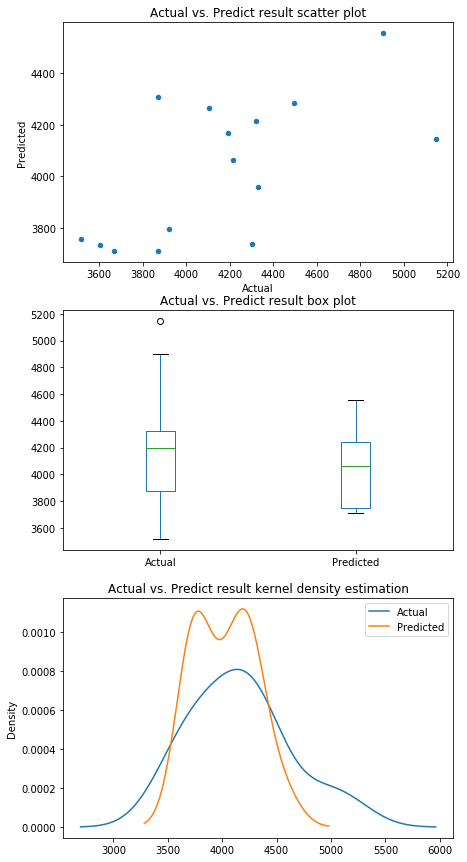

In [70]:
visualize_graph(df_pred_ANN_r)

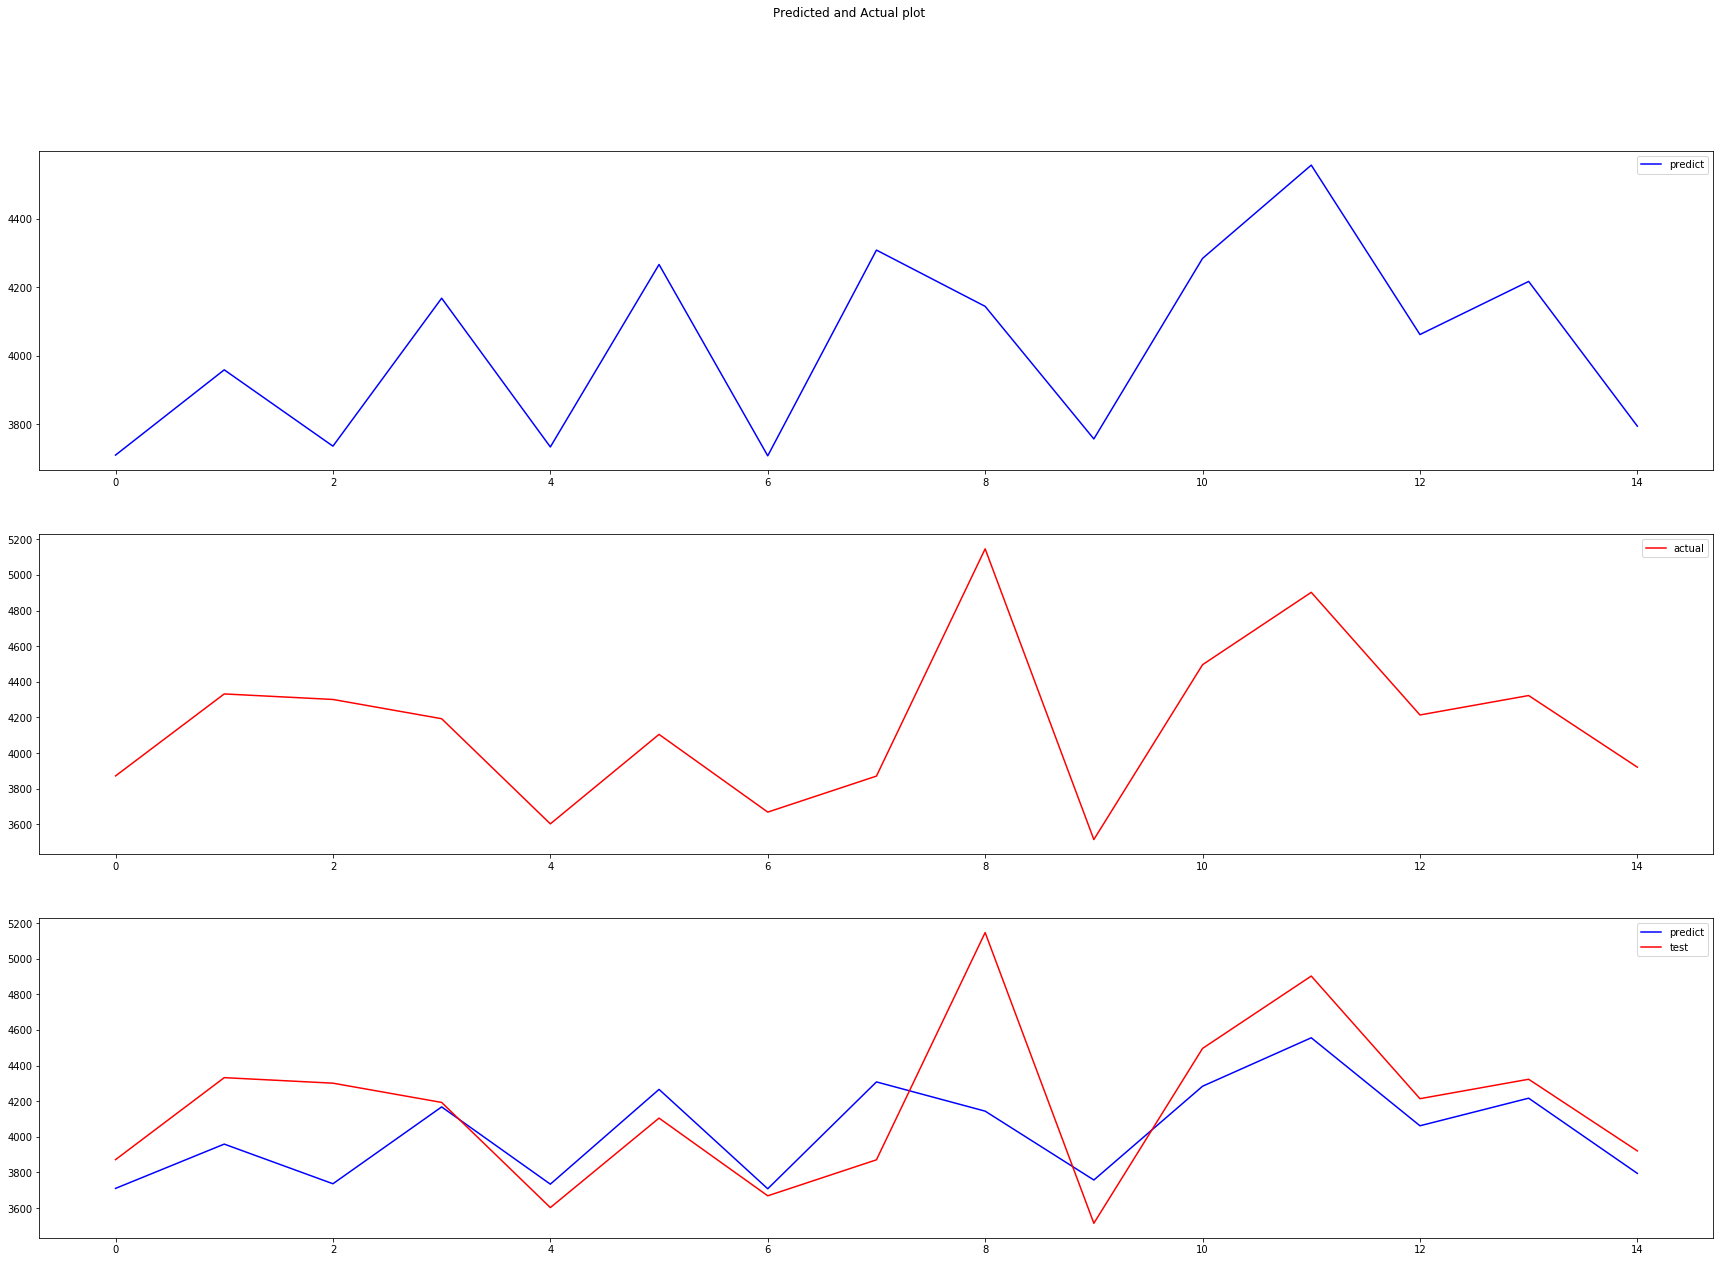

In [71]:
visualization(df_pred_ANN_r.Actual, df_pred_ANN_r.Predicted)